In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import os, sys, json
import numpy as np
import pandas as pd
import seaborn as sns

from copy import copy
from glob import glob
from tqdm.auto import tqdm as tqdm
import matplotlib.pyplot as plt

In [4]:
sys.path.append('../mouseland/model_opts')
from model_options import *
model_options = get_model_options(model_type='imagenet', train_type='imagenet')
model_names = [model_options[model_option]['model_name'] for model_option in model_options]

In [5]:
all_response_data = (pd.read_csv('aesthetic_responses.csv')
                 .groupby(['Subj','ImageType','Image'])
                 .agg({'Rating': 'mean', 'RT': 'mean'}).reset_index())
all_response_data.columns = ['subject','image_type','image_name','rating','reaction_time']
response_data = all_response_data.groupby(['image_type','image_name'])['rating'].mean().reset_index()

In [6]:
all_response_data

,subject,image_type,image_name,rating,reaction_time
0,1,are,aep_001.jpg,3.666667,0.899933
1,1,are,aep_002.jpg,4.333333,0.761233
2,1,are,aep_004.jpg,1.000000,0.997700
3,1,are,aep_005.jpg,5.666667,0.854033
4,1,are,aep_006.jpg,6.333333,1.761233
...,...,...,...,...,...
10933,24,art,art_105.jpg,1.000000,0.836700
10934,24,art,art_106.jpg,1.000000,0.723550
10935,24,art,art_107.jpg,1.000000,0.701400
10936,24,art,art_108.jpg,1.500000,1.554850


### Response Statistics

In [7]:
from scipy.stats import pearsonr

oracle_corr_dictlist = []
data_i = copy(all_response_data)
for image_type in data_i['image_type'].unique():
    data_i_subset = data_i[data_i['image_type'] == image_type]
    for subject in data_i_subset['subject'].unique():
        group_data_i = (data_i_subset[data_i_subset['subject'] != subject].groupby('image_name')['rating']
                        .mean().reset_index()['rating']).to_numpy()
        subject_data_i = data_i_subset[data_i_subset['subject'] == subject]['rating'].to_numpy()
        oracle_corr_dictlist.append({'subject': subject, 'image_type': image_type, 
                                     'oracle_corr': pearsonr(subject_data_i, group_data_i)[0]})

oracle_corrs = pd.DataFrame(oracle_corr_dictlist)

In [8]:
oracle_corrs.groupby(['image_type'])['oracle_corr'].mean().reset_index()

,image_type,oracle_corr
0,are,0.350528
1,ari,0.368043
2,art,0.274922
3,fac,0.791038
4,lsc,0.575650


In [9]:
from toolbox.reliability import split_half

splithalf_corr_dictlist = []

data_i = copy(all_response_data).drop('reaction_time', 1)
for image_type in data_i['image_type'].unique():
    data_i_subset = data_i[data_i['image_type'] == image_type]
    data_i_subset = data_i_subset.pivot(index='subject', columns='image_name', values='rating').to_numpy()
    splithalf_corr_dictlist.append({'image_type': image_type, 'splithalf_r': split_half(data_i_subset, n_splits=10000)[0]})

splithalf_corrs = pd.DataFrame(splithalf_corr_dictlist)

In [10]:
splithalf_corrs

,image_type,splithalf_r
0,are,0.782390
1,ari,0.796147
2,art,0.719318
3,fac,0.980349
4,lsc,0.912794


### Data Processing

In [11]:
def process_model_data(model_name, orient='wide'):
    model_data = (pd.read_csv('feature_maps/{}.csv'.format(model_name))
                  .drop(['image_type','model_layer_index'], axis = 1))
    sparsity_data = (pd.read_csv('sparsity/{}.csv'.format(model_name))
                    .drop(['image_type','model_layer_index', 'mean_activity'], axis = 1))
    model_data = pd.merge(model_data, sparsity_data, on = ['image_name','model','model_layer'])
    data_wide = pd.merge(model_data, response_data, on = 'image_name')
    model_layers = data_wide['model_layer'].unique().tolist()
    data_wide['model_layer_index'] = data_wide.apply(lambda x: model_layers.index(x['model_layer']) + 1, axis = 1)
    id_columns = ['image_name','image_type','model', 'model_layer', 'model_layer_index', 'rating']
    data_wide = data_wide[id_columns + [col for col in data_wide.columns.to_list() if col not in id_columns]]
    data_long = pd.melt(data_wide, id_vars=id_columns, 
                var_name = 'metric', value_name='value')
    
    if orient == 'wide':
        return(data_wide)
    if orient == 'long':
        return(data_long)

In [12]:
target_model = 'alexnet'
data_wide = process_model_data(target_model)

In [13]:
data_wide

,image_name,image_type,model,model_layer,model_layer_index,rating,mean_activity,total_activity,cosine_to_noise_mean,distance_to_noise_mean,cosine_to_imagenet_mean,distance_to_imagenet_mean,mean_cosine_to_noise,mean_distance_to_noise,mean_cosine_to_imagenet,mean_distance_to_imagenet,sparseness
0,aep_010.jpg,are,alexnet,Conv2d-1,1,4.350877,2.098905,4.063480e+05,0.247803,1265.723389,0.274310,1253.159424,0.078414,1778.658569,0.110958,1556.457520,1.657185e-02
1,aep_010.jpg,are,alexnet,ReLU-1,2,4.350877,0.858862,1.662757e+05,0.432170,752.852966,0.451760,744.144592,0.244744,1030.323853,0.198562,911.712158,2.109780e-01
2,aep_010.jpg,are,alexnet,MaxPool2d-1,3,4.350877,2.961493,1.381714e+05,0.702107,665.060425,0.776654,626.937988,0.647638,757.618958,0.485665,768.319397,5.579752e-01
3,aep_010.jpg,are,alexnet,Conv2d-2,4,4.350877,14.393755,2.014665e+06,0.775998,5191.627441,0.878941,5136.732422,0.762378,5396.756348,0.610894,6188.254883,4.050440e-01
4,aep_010.jpg,are,alexnet,ReLU-2,5,4.350877,0.600872,8.410281e+04,0.191747,1307.588501,0.434475,757.996399,0.183422,1355.915039,0.178709,1022.134399,7.187308e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,art_016.jpg,art,alexnet,Linear-1,14,3.333333,5.466929,2.239254e+04,0.035522,479.099854,0.649782,337.816681,0.035220,479.821106,0.376367,538.387329,3.409078e-01
10112,art_016.jpg,art,alexnet,ReLU-6,15,3.333333,0.707121,2.896369e+03,0.126953,134.538895,0.416303,105.766457,0.125259,135.293060,0.175966,167.501434,1.532098e-01
10113,art_016.jpg,art,alexnet,Linear-2,16,3.333333,4.720512,1.933522e+04,0.430819,368.663025,0.751203,272.208252,0.429673,369.440460,0.589364,420.776093,4.808307e-01
10114,art_016.jpg,art,alexnet,ReLU-7,17,3.333333,0.324582,1.329489e+03,0.010872,85.429581,0.299671,68.053207,0.010738,85.785507,0.079868,101.876427,8.481777e-02


In [14]:
def process_corr_data(data_wide, orient='long'):
    model_layers = data_wide['model_layer'].unique().tolist()
    id_columns = ['model','image_type','model_layer', 'model_layer_index']
    corr_data_wide = (data_wide.groupby(id_columns)
             .corrwith(data_wide['rating']).reset_index().drop('rating',axis = 1))
    corr_data_long = pd.melt(corr_data_wide, id_vars = id_columns, 
                             var_name = 'metric', value_name='corr')
    
    if orient == 'wide':
        return(corr_data_wide)
    if orient == 'long':
        return(corr_data_long)

In [15]:
corr_data_long = process_corr_data(data_wide)

In [17]:
corr_data_long.image_type.unique()

array(['are', 'ari', 'art', 'fac', 'lsc'], dtype=object)

In [18]:
corr_data_long.model_layer_index.unique()

array([ 1,  4,  7,  9, 11, 14, 16, 18,  3,  6, 13,  2,  5,  8, 10, 12, 15,
       17])

In [19]:
corr_data_long.model.unique()

array(['alexnet'], dtype=object)

In [20]:
def max_transform(df, group_vars, measure_var = 'score', deduplicate=True):
    if not isinstance(group_vars, list):
        group_vars = list(group_vars)
    
    max_df = (df[df.groupby(group_vars)[measure_var]
                 .transform(max) == df[measure_var]]).reset_index(drop=True)
                 
    if deduplicate:
        max_df = max_df[~max_df.duplicated(group_vars + [measure_var])]
        
    return max_df

In [21]:
corr_max = max_transform(corr_data_long, group_vars=['model','image_type', 'metric'], measure_var = 'corr')

In [22]:
corr_max[corr_max['image_type'] == 'lsc'].sort_values(by='corr')

,model,image_type,model_layer,model_layer_index,metric,corr
14,alexnet,lsc,Linear-3,18,cosine_to_noise_mean,0.246295
34,alexnet,lsc,Linear-3,18,mean_cosine_to_noise,0.246382
44,alexnet,lsc,Linear-1,14,mean_cosine_to_imagenet,0.397076
24,alexnet,lsc,Linear-1,14,cosine_to_imagenet_mean,0.407879
54,alexnet,lsc,Linear-1,14,sparseness,0.438950
4,alexnet,lsc,ReLU-5,12,mean_activity,0.511019
9,alexnet,lsc,ReLU-5,12,total_activity,0.511019
49,alexnet,lsc,ReLU-5,12,mean_distance_to_imagenet,0.517614
29,alexnet,lsc,ReLU-5,12,distance_to_imagenet_mean,0.543648
39,alexnet,lsc,MaxPool2d-3,13,mean_distance_to_noise,0.553026


In [23]:
corr_max[(corr_max['image_type'] == 'lsc') & (corr_max['metric'] == 'mean_activity')]['model_layer'].iloc[0]

'ReLU-5'

In [25]:
corr_data_long

,model,image_type,model_layer,model_layer_index,metric,corr
0,alexnet,are,Conv2d-1,1,mean_activity,0.011647
1,alexnet,are,Conv2d-2,4,mean_activity,0.027119
2,alexnet,are,Conv2d-3,7,mean_activity,-0.068520
3,alexnet,are,Conv2d-4,9,mean_activity,-0.176181
4,alexnet,are,Conv2d-5,11,mean_activity,-0.276747
...,...,...,...,...,...,...
985,alexnet,lsc,ReLU-3,8,sparseness,-0.382702
986,alexnet,lsc,ReLU-4,10,sparseness,0.286813
987,alexnet,lsc,ReLU-5,12,sparseness,0.294431
988,alexnet,lsc,ReLU-6,15,sparseness,-0.497647


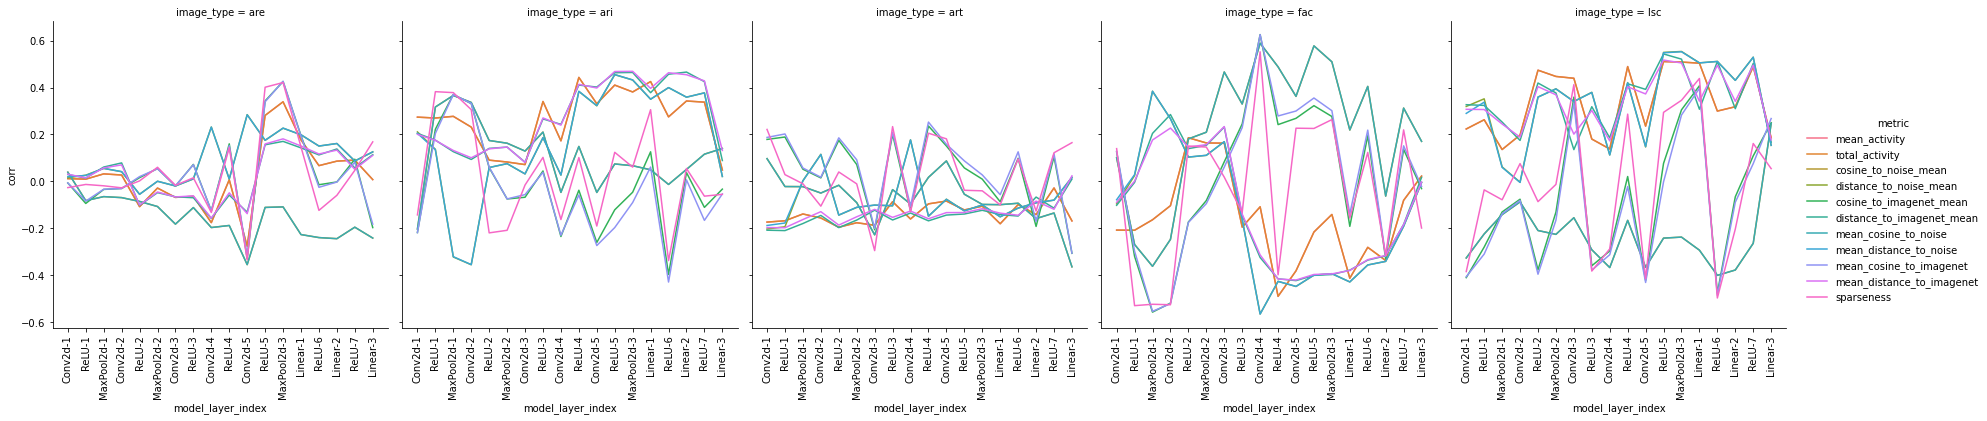

In [27]:
g = sns.relplot(x='model_layer_index',y='corr', kind='line', hue='metric', col = 'image_type', data = corr_data_long)
[ax.set_xticks(np.sort(corr_data_long['model_layer_index'].unique())) for ax in g.axes.flat];
[ax.set_xticklabels(data_wide['model_layer'].unique().tolist(), rotation=90) for ax in g.axes.flat];

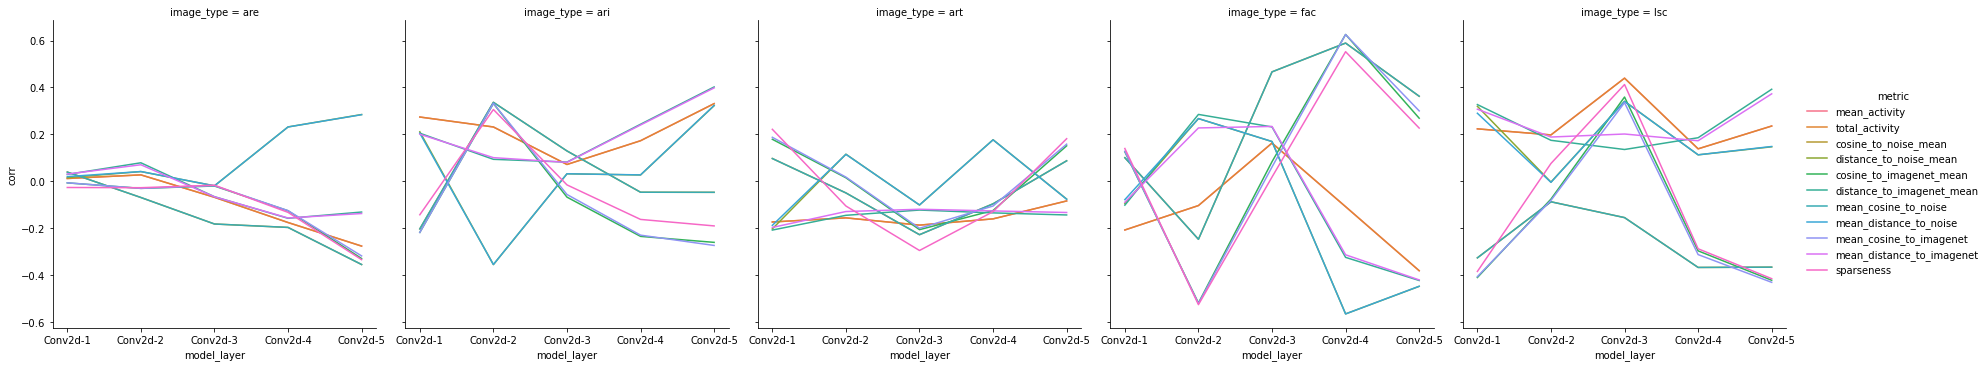

In [28]:
g = sns.relplot(x='model_layer',y='corr', kind='line', hue='metric', col = 'image_type', 
                data = corr_data_long.loc[corr_data_long['model_layer'].str.contains('Conv')]);

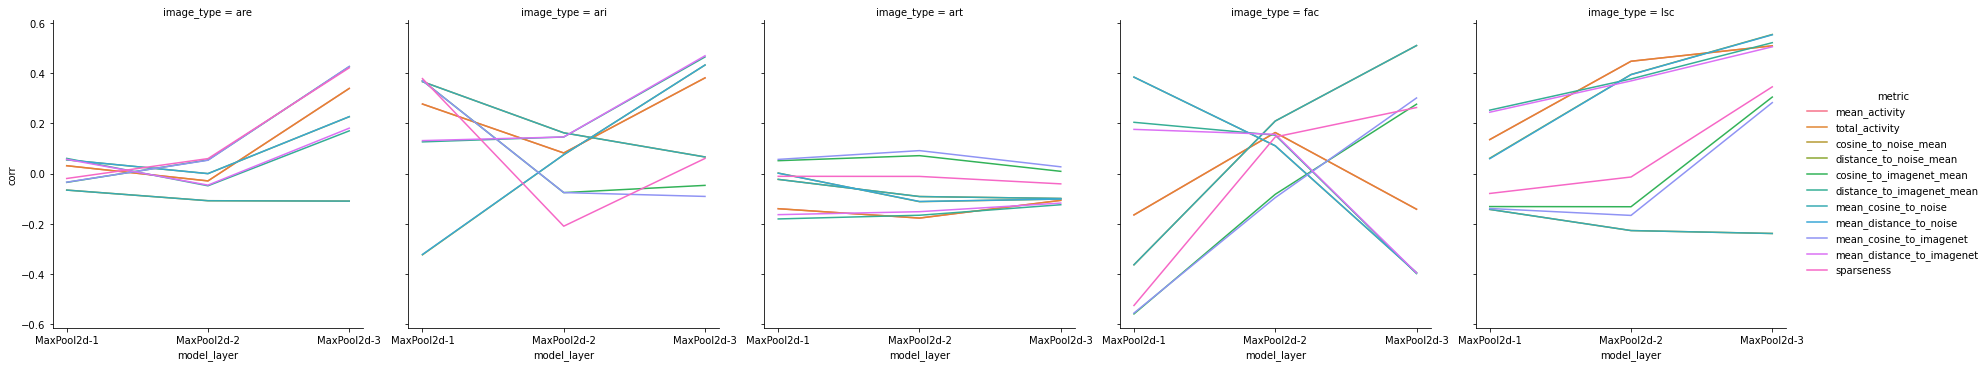

In [29]:
g = sns.relplot(x='model_layer',y='corr', kind='line', hue='metric', col = 'image_type', 
                data = corr_data_long.loc[corr_data_long['model_layer'].str.contains('MaxPool')]);

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from scipy.stats import pearsonr

In [32]:
data_i = corr_data_long[(corr_data_long['image_type'] == 'lsc') & (corr_data_long['metric'] == 'mean_activity')]
x = data_i['model_layer_index'].to_numpy().reshape(-1,1)
y = data_i['corr'].to_numpy()
regression = LinearRegression().fit(x,y)
regression.coef_

array([0.00808868])

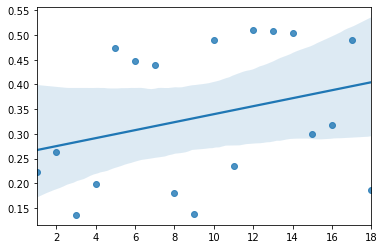

In [34]:
sns.regplot(x,y);

In [35]:
data_i = data_wide[(data_wide['image_type'] == 'lsc')]
y = data_i[(data_i['model_layer']=='Conv2d-1')]['rating'].to_numpy()
X = np.stack([data_i[(data_i['model_layer']==model_layer)]['mean_activity'].to_numpy() 
              for model_layer in data_i['model_layer'].unique()], axis = 1)

In [36]:
regression = Ridge(alpha=1.0).fit(X,y)
regression.score(X,y)

0.41255860811833267

In [37]:
regression = RidgeCV(alphas=[1.0], store_cv_values=True, scoring='r2').fit(X,y)
pearsonr(y, regression.cv_values_.squeeze())[0]**2

0.32486771938556674

In [38]:
target_model = 'alexnet'
data_long = process_model_data('alexnet', orient='long')

In [39]:
(data_long[(data_long['image_name'].isin(['art_105.jpg','art_109.jpg'])) & (data_long['metric'] == 'mean_activity')]
 .groupby('image_name')['value'].mean())

image_name
art_105.jpg    2.271646
art_109.jpg    2.900821
Name: value, dtype: float64

In [41]:
data_long[(data_long['metric'] == 'mean_activity')].groupby('image_name')['value'].mean().sort_values()

image_name
eqlsc011.jpg    1.031393
eqlsc060.jpg    1.340349
eqlsc012.jpg    1.347827
eqlsc089.jpg    1.354100
eqlsc062.jpg    1.358757
                  ...   
art_004.jpg     4.475927
art_068.jpg     4.608078
art_103.jpg     4.740064
art_096.jpg     5.374900
art_108.jpg     6.153128
Name: value, Length: 562, dtype: float64

In [42]:
data_long[(data_long['metric'] == 'mean_cosine_to_imagenet')].groupby('image_name')['value'].mean().sort_values()

image_name
art_105.jpg     0.243777
eqlsc075.jpg    0.252571
eqlsc067.jpg    0.254069
art_104.jpg     0.259777
eqlsc066.jpg    0.260342
                  ...   
art_048.jpg     0.305884
aip_060.jpg     0.306135
art_024.jpg     0.307605
art_053.jpg     0.311404
art_050.jpg     0.312801
Name: value, Length: 562, dtype: float64

In [43]:
data_long.groupby('metric')['value'].min()

metric
cosine_to_imagenet_mean     -1.408612e-01
cosine_to_noise_mean        -1.790731e-01
distance_to_imagenet_mean    3.866929e+01
distance_to_noise_mean       5.725194e+01
mean_activity                6.469998e-02
mean_cosine_to_imagenet     -5.277558e-02
mean_cosine_to_noise        -1.776104e-01
mean_distance_to_imagenet    8.471311e+01
mean_distance_to_noise       5.777496e+01
sparseness                   5.811476e-11
total_activity               5.354371e+02
Name: value, dtype: float64

In [44]:
data_long.groupby('metric')['value'].std()

metric
cosine_to_imagenet_mean           0.182729
cosine_to_noise_mean              0.219484
distance_to_imagenet_mean       789.906889
distance_to_noise_mean         1527.037018
mean_activity                     2.789100
mean_cosine_to_imagenet           0.178857
mean_cosine_to_noise              0.217290
mean_distance_to_imagenet      1143.972823
mean_distance_to_noise         1557.803467
sparseness                        0.172920
total_activity               256395.128135
Name: value, dtype: float64

In [45]:
data_i = data_long[(data_long['image_type'] == 'lsc') & (data_long['metric'] == 'mean_activity')]
y = data_i[(data_i['model_layer']==data_i['model_layer'].unique()[0])]['rating'].to_numpy()
X = np.stack([data_i[(data_i['model_layer']==model_layer)]['value'].to_numpy() 
              for model_layer in data_i['model_layer'].unique()], axis = 1)
regression = Ridge(alpha=1.0).fit(X,y)
regression.score(X,y)

0.41255860811833267

In [46]:
model_csvs = glob('feature_maps/*.csv')
target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]

output_file = 'raw_results.csv'
if os.path.exists(output_file):
    raw_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dflist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model)
        data_wide = process_model_data(target_model)
        
        results_dflist.append(data_wide)

    raw_results = pd.concat(results_dflist)
    raw_results.to_csv(output_file, index = None)

In [47]:
model_csvs = glob('feature_maps/*.csv')
target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]

output_file = 'correlation_results.csv'
if os.path.exists(output_file):
    corr_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dflist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model)
        data_wide = process_model_data(target_model)
        corr_data_long = process_corr_data(data_wide)
        
        results_dflist.append(corr_data_long)

    corr_results = pd.concat(results_dflist)
    corr_results.to_csv(output_file, index = None)

In [48]:
model_csvs = glob('feature_maps/*.csv')
target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]

output_file = 'analysis_results.csv'
if os.path.exists(output_file):
    results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dictlist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model) 
        data_wide = process_model_data(target_model)
        model_layers = data_wide['model_layer'].unique()
        corr_results_subset = corr_results[corr_results['model']==target_model]
        corr_max = max_transform(corr_results_subset, group_vars=['model','image_type', 'metric'], measure_var = 'corr')

        for metric in tqdm(corr_data_long['metric'].unique(), leave=False):
            for image_type in tqdm(corr_data_long['image_type'].unique(), leave=False):
                corr_max_subset = corr_max[(corr_max['image_type'] == image_type) & (corr_max['metric'] == metric)]
                corr_max_layer = corr_max_subset['model_layer'].iloc[0]
                corr_max_depth = corr_max_subset['model_layer_relative'].iloc[0]
                corr_max_value = corr_max_subset['corr'].iloc[0]

                data_i = corr_results_subset[(corr_results_subset['image_type'] == image_type) & 
                                             (corr_results_subset['metric'] == metric)]
                x, y = data_i['model_layer_relative'].to_numpy().reshape(-1,1), data_i['corr'].to_numpy()
                regression = LinearRegression().fit(x,y)
                corr_depth_coef = regression.coef_[0]

                data_i = data_wide[(data_wide['image_type'] == image_type)]
                y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
                X = np.stack([data_i[(data_i['model_layer']==model_layer)][metric].to_numpy() 
                              for model_layer in model_layers], axis = 1)
                regression = RidgeCV(alphas=[1.0], store_cv_values=True, scoring='r2').fit(X,y)
                ridge_pearson_r2_gcv = pearsonr(y, regression.cv_values_.squeeze())[0]**2

                results_dictlist.append({'model': target_model, 'image_type': image_type, 'metric': metric,
                                         'ridge_pearson_r2_gcv': ridge_pearson_r2_gcv,
                                         'corr_max_value': corr_max_value, 
                                         'corr_max_layer': corr_max_layer,
                                         'corr_max_depth': corr_max_depth, 
                                         'model_depth': len(model_layers),
                                         'corr_max_relative_depth': corr_max_depth / len(model_layers), 
                                         'corr_depth_coef': corr_depth_coef})

    results = pd.DataFrame(results_dictlist)
    results.to_csv(output_file, index = None)

In [49]:
results['ridge_pearson_r2_gcv'] = np.round(results['ridge_pearson_r2_gcv'], 5)

In [50]:
max_transform(results[results['metric'] == 'mean_activity'], group_vars = ['metric', 'image_type'],
              measure_var = 'corr_max_value').sort_values(by=['image_type','corr_max_value'])

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
0,vgg13_bn,are,mean_activity,0.152657,0.08510,0.434638,MaxPool2d-5,35,40,0.875000,0.005056
4,vgg13,ari,mean_activity,0.350143,0.17764,0.499666,Linear-2,28,30,0.933333,-0.000520
1,resnet101,art,mean_activity,0.115733,0.04310,0.277649,Conv2d-40,89,234,0.380342,-0.000065
2,resnet101,fac,mean_activity,0.091375,0.03994,0.628053,Conv2d-7,16,234,0.068376,-0.000198
3,resnet101,lsc,mean_activity,0.358034,0.35631,0.596426,BatchNorm2d-92,206,234,0.880342,0.000415


In [51]:
max_transform(results[results['metric'] == 'sparseness'], group_vars = ['metric', 'image_type'],
              measure_var = 'corr_max_value').sort_values(by=['image_type','corr_max_value'])

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
0,alexnet,are,sparseness,0.055740,0.01616,0.421588,MaxPool2d-3,13,18,0.722222,0.008038
4,resnext50_32x4d,ari,sparseness,0.283083,0.25926,0.524621,Conv2d-52,115,121,0.950413,0.000566
2,googlenet,art,sparseness,0.159966,0.02274,0.415161,BasicConv2d-38,127,195,0.651282,-0.000290
3,shufflenet_v2_x0_5,fac,sparseness,0.134205,0.27927,0.695396,ReLU-34,153,167,0.916168,0.000640
1,densenet201,lsc,sparseness,0.595926,0.49988,0.561943,Conv2d-64,197,610,0.322951,0.000415


In [52]:
max_transform(results[results['metric'] == 'mean_activity'], group_vars = ['metric', 'image_type'],
              measure_var = 'ridge_pearson_r2_gcv').sort_values(by=['image_type','ridge_pearson_r2_gcv'])

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
4,vgg16,are,mean_activity,0.363897,0.19350,0.379560,MaxPool2d-5,31,36,0.861111,0.006251
0,vgg16_bn,ari,mean_activity,0.253664,0.18662,0.459104,Linear-2,47,49,0.959184,-0.001970
1,vgg19,art,mean_activity,0.249753,0.04427,0.079155,ReLU-18,41,42,0.976190,0.000310
3,vgg13,fac,mean_activity,0.636630,0.53283,0.225600,Linear-3,30,30,1.000000,0.003100
2,vgg19,lsc,mean_activity,0.551029,0.43619,0.575970,ReLU-15,34,42,0.809524,0.008058


In [53]:
max_transform(results[results['metric'] == 'sparseness'], group_vars = ['metric', 'image_type'],
              measure_var = 'ridge_pearson_r2_gcv').sort_values(by=['image_type','ridge_pearson_r2_gcv'])

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
0,densenet201,are,sparseness,0.290506,0.09066,0.382312,ReLU-103,313,610,0.513115,-0.000038
1,densenet201,ari,sparseness,0.493873,0.35400,0.495748,BatchNorm2d-154,467,610,0.765574,-0.000002
4,resnet152,art,sparseness,0.271253,0.14385,0.359915,BatchNorm2d-56,126,348,0.362069,-0.000385
2,densenet201,fac,sparseness,0.457203,0.57151,0.616297,Conv2d-94,287,610,0.470492,-0.000125
3,densenet201,lsc,sparseness,0.595926,0.49988,0.561943,Conv2d-64,197,610,0.322951,0.000415


In [54]:
results[results['metric'] == 'mean_activity'].groupby(['image_type'])['corr_max_relative_depth'].mean()

image_type
are    0.781765
ari    0.384683
art    0.613197
fac    0.789644
lsc    0.443970
Name: corr_max_relative_depth, dtype: float64

In [55]:
results[results['image_type'] == 'lsc'].sort_values(by='corr_max_value')

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
654,squeezenet1_0,lsc,mean_distance_to_imagenet,0.341639,0.03534,-0.004913,ReLU-1,2,64,0.031250,-0.001531
634,squeezenet1_0,lsc,distance_to_imagenet_mean,0.362177,0.02902,-0.002103,Conv2d-1,1,64,0.015625,-0.001614
614,squeezenet1_0,lsc,total_activity,0.410269,0.00198,0.038083,ReLU-3,7,64,0.109375,-0.001382
609,squeezenet1_0,lsc,mean_activity,0.252386,0.00009,0.038083,ReLU-3,7,64,0.109375,-0.001382
214,squeezenet1_1,lsc,mean_distance_to_imagenet,0.427216,0.00032,0.042563,ReLU-6,14,64,0.218750,-0.000953
...,...,...,...,...,...,...,...,...,...,...,...
964,vgg13,lsc,distance_to_imagenet_mean,0.579533,0.34718,0.579698,ReLU-10,24,30,0.800000,0.003987
469,vgg11_bn,lsc,distance_to_imagenet_mean,0.617429,0.37896,0.581965,ReLU-8,28,34,0.823529,0.002427
689,resnet101,lsc,distance_to_imagenet_mean,0.965280,0.27222,0.583481,Conv2d-35,78,234,0.333333,-0.000148
664,resnet101,lsc,mean_activity,0.358034,0.35631,0.596426,BatchNorm2d-92,206,234,0.880342,0.000415


In [56]:
results.sort_values(by='ridge_standard_r2_nocv')

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
648,squeezenet1_0,fac,mean_cosine_to_imagenet,0.017796,0.09899,0.232091,Conv2d-26,62,64,0.968750,0.002935
647,squeezenet1_0,art,mean_cosine_to_imagenet,0.018899,0.17739,0.161852,MaxPool2d-3,54,64,0.843750,-0.000236
1048,wide_resnet50_2,fac,mean_activity,0.019424,0.18688,0.105266,Conv2d-34,75,121,0.619835,0.000217
1320,resnext50_32x4d,are,mean_activity,0.019800,0.06305,0.169682,Conv2d-40,89,121,0.735537,0.001345
1323,resnext50_32x4d,fac,mean_activity,0.020561,0.10061,0.125606,Conv2d-39,87,121,0.719008,0.000756
...,...,...,...,...,...,...,...,...,...,...,...
669,resnet101,lsc,total_activity,1.000000,0.28344,0.596426,BatchNorm2d-92,206,234,0.880342,0.000415
668,resnet101,fac,total_activity,1.000000,0.26417,0.628053,Conv2d-7,16,234,0.068376,-0.000198
665,resnet101,are,total_activity,1.000000,0.00000,0.280053,Conv2d-90,200,234,0.854701,0.000658
666,resnet101,ari,total_activity,1.000000,0.03754,0.387564,BatchNorm2d-83,186,234,0.794872,-0.000340


In [57]:
results.sort_values(by='ridge_pearson_r2_gcv')

,model,image_type,metric,ridge_standard_r2_nocv,ridge_pearson_r2_gcv,corr_max_value,corr_max_layer,corr_max_depth,model_depth,corr_max_relative_depth,corr_depth_coef
1275,mnasnet0_5,are,cosine_to_noise_mean,0.132540,0.00000,0.122160,Conv2d-18,49,151,0.324503,0.000520
565,densenet201,are,distance_to_noise_mean,0.958490,0.00000,0.205884,Conv2d-150,457,610,0.749180,0.000020
1395,mnasnet1_0,are,cosine_to_imagenet_mean,0.128248,0.00000,0.233105,ReLU-33,141,151,0.933775,-0.000770
1419,mnasnet1_0,lsc,mean_cosine_to_imagenet,0.063336,0.00000,0.180768,Conv2d-52,147,151,0.973510,0.000334
1127,shufflenet_v2_x1_0,art,distance_to_imagenet_mean,0.964335,0.00000,0.142472,Conv2d-15,42,167,0.251497,-0.000694
...,...,...,...,...,...,...,...,...,...,...,...
358,vgg13_bn,fac,distance_to_imagenet_mean,0.870433,0.57893,0.544823,Linear-3,40,40,1.000000,0.000304
158,resnet34,fac,mean_distance_to_imagenet,0.910034,0.57991,0.369654,Conv2d-12,28,84,0.333333,0.000034
138,resnet34,fac,distance_to_imagenet_mean,0.930472,0.58180,0.370569,Conv2d-12,28,84,0.333333,0.000039
128,resnet34,fac,distance_to_noise_mean,0.934091,0.61004,0.322808,Linear-1,84,84,1.000000,-0.000058


In [58]:
results.groupby(['metric'])['corr_max_value'].mean().sort_values()

metric
mean_cosine_to_noise         0.247944
cosine_to_noise_mean         0.247955
mean_distance_to_imagenet    0.248791
distance_to_imagenet_mean    0.249378
distance_to_noise_mean       0.253985
mean_distance_to_noise       0.254730
mean_activity                0.269020
total_activity               0.269020
mean_cosine_to_imagenet      0.293619
cosine_to_imagenet_mean      0.297153
sparseness                   0.418564
Name: corr_max_value, dtype: float64

In [59]:
results.groupby(['metric'])['corr_max_value'].max().sort_values()

metric
mean_distance_to_noise       0.571007
distance_to_noise_mean       0.572546
mean_distance_to_imagenet    0.576477
distance_to_imagenet_mean    0.583481
total_activity               0.628053
mean_activity                0.628053
cosine_to_imagenet_mean      0.634219
mean_cosine_to_imagenet      0.642136
cosine_to_noise_mean         0.667494
mean_cosine_to_noise         0.667502
sparseness                   0.695396
Name: corr_max_value, dtype: float64

In [60]:
results.groupby(['metric'])['ridge_pearson_r2_gcv'].mean().sort_values()

metric
mean_cosine_to_imagenet      0.073564
mean_cosine_to_noise         0.088070
cosine_to_noise_mean         0.088209
cosine_to_imagenet_mean      0.094039
total_activity               0.100420
mean_activity                0.100587
distance_to_imagenet_mean    0.106463
mean_distance_to_imagenet    0.107272
mean_distance_to_noise       0.116092
distance_to_noise_mean       0.118745
sparseness                   0.176340
Name: ridge_pearson_r2_gcv, dtype: float64

In [61]:
results.groupby(['metric'])['ridge_pearson_r2_gcv'].max().sort_values()

metric
mean_cosine_to_imagenet      0.41111
cosine_to_imagenet_mean      0.47511
cosine_to_noise_mean         0.47531
mean_cosine_to_noise         0.48516
mean_activity                0.53283
total_activity               0.55438
sparseness                   0.57151
mean_distance_to_imagenet    0.57991
distance_to_imagenet_mean    0.58180
distance_to_noise_mean       0.61004
mean_distance_to_noise       0.62372
Name: ridge_pearson_r2_gcv, dtype: float64

In [62]:
oracle_corrs

,subject,image_type,oracle_corr
0,1,are,0.298391
1,2,are,0.270648
2,3,are,0.306731
3,4,are,0.584342
4,5,are,0.413428
...,...,...,...
93,14,lsc,0.612879
94,15,lsc,0.542873
95,16,lsc,0.188906
96,17,lsc,0.665884


In [63]:
oracle_corrs.groupby(['image_type'])['oracle_corr'].mean().reset_index()

,image_type,oracle_corr
0,are,0.350528
1,ari,0.368043
2,art,0.274922
3,fac,0.791038
4,lsc,0.575650


In [64]:
results.groupby(['image_type'])['corr_max_value'].mean().sort_values()

image_type
art    0.183880
are    0.231192
ari    0.310750
lsc    0.321258
fac    0.339357
Name: corr_max_value, dtype: float64

In [65]:
results.groupby(['image_type'])['corr_max_value'].max().sort_values()

image_type
art    0.425402
are    0.441887
ari    0.524621
lsc    0.596426
fac    0.695396
Name: corr_max_value, dtype: float64

In [66]:
results.groupby(['image_type'])['ridge_pearson_r2_gcv'].mean().sort_values()

image_type
art    0.028432
are    0.039164
ari    0.090418
fac    0.185478
lsc    0.188236
Name: ridge_pearson_r2_gcv, dtype: float64

In [67]:
results.groupby(['image_type'])['ridge_pearson_r2_gcv'].max().sort_values()

image_type
art    0.17739
are    0.23328
ari    0.42687
lsc    0.49988
fac    0.62372
Name: ridge_pearson_r2_gcv, dtype: float64

In [68]:
results[results.image_type == 'lsc'].groupby(['metric'])['corr_max_value'].mean().sort_values()

metric
mean_cosine_to_noise         0.234646
cosine_to_noise_mean         0.234698
mean_cosine_to_imagenet      0.294020
cosine_to_imagenet_mean      0.296718
mean_distance_to_imagenet    0.309559
distance_to_imagenet_mean    0.317033
mean_distance_to_noise       0.343995
mean_activity                0.344389
total_activity               0.344389
distance_to_noise_mean       0.344423
sparseness                   0.469972
Name: corr_max_value, dtype: float64

In [69]:
results.groupby(['metric'])['corr_max_relative_depth'].mean().sort_values()

metric
mean_cosine_to_noise         0.498540
cosine_to_noise_mean         0.502322
mean_distance_to_noise       0.547561
distance_to_noise_mean       0.548717
sparseness                   0.577711
cosine_to_imagenet_mean      0.590467
mean_activity                0.602652
total_activity               0.602652
mean_cosine_to_imagenet      0.605965
mean_distance_to_imagenet    0.618669
distance_to_imagenet_mean    0.635278
Name: corr_max_relative_depth, dtype: float64

In [70]:
results.groupby(['image_type'])['corr_max_relative_depth'].mean().sort_values()

image_type
ari    0.346943
art    0.509729
lsc    0.594340
are    0.701157
fac    0.725348
Name: corr_max_relative_depth, dtype: float64

In [71]:
(results[results.image_type == 'lsc'].groupby(['model'])['corr_max_value'].mean()**2).sort_values()

model
squeezenet1_0         0.015064
squeezenet1_1         0.018371
mnasnet0_5            0.026054
mnasnet1_0            0.026943
googlenet             0.028334
shufflenet_v2_x0_5    0.030040
shufflenet_v2_x1_0    0.031222
mobilenet_v2          0.031401
wide_resnet50_2       0.032903
densenet121           0.035524
resnext50_32x4d       0.035919
resnet152             0.039857
wide_resnet101_2      0.043149
densenet201           0.043332
densenet169           0.046916
vgg13                 0.190833
alexnet               0.200635
vgg16                 0.207207
vgg11                 0.218545
vgg19_bn              0.226352
vgg16_bn              0.230414
resnet18              0.237228
resnet50              0.243764
resnet34              0.253312
resnet101             0.257895
vgg13_bn              0.270752
vgg11_bn              0.273451
vgg19                 0.276584
Name: corr_max_value, dtype: float64

In [72]:
results[results.image_type == 'lsc'].groupby(['model'])['ridge_pearson_r2_gcv'].mean().sort_values()

model
mobilenet_v2          0.026973
mnasnet1_0            0.035338
squeezenet1_0         0.040011
googlenet             0.042650
wide_resnet101_2      0.044328
densenet121           0.044497
squeezenet1_1         0.044800
resnext50_32x4d       0.045075
densenet169           0.045080
mnasnet0_5            0.045531
shufflenet_v2_x0_5    0.045832
resnet152             0.047600
densenet201           0.048175
shufflenet_v2_x1_0    0.048580
wide_resnet50_2       0.054365
alexnet               0.309964
vgg13                 0.325119
vgg16_bn              0.329196
vgg11                 0.337355
resnet18              0.352859
vgg16                 0.353644
vgg19_bn              0.358040
resnet101             0.360424
vgg13_bn              0.361629
resnet50              0.371645
vgg11_bn              0.375221
resnet34              0.383470
vgg19                 0.393217
Name: ridge_pearson_r2_gcv, dtype: float64

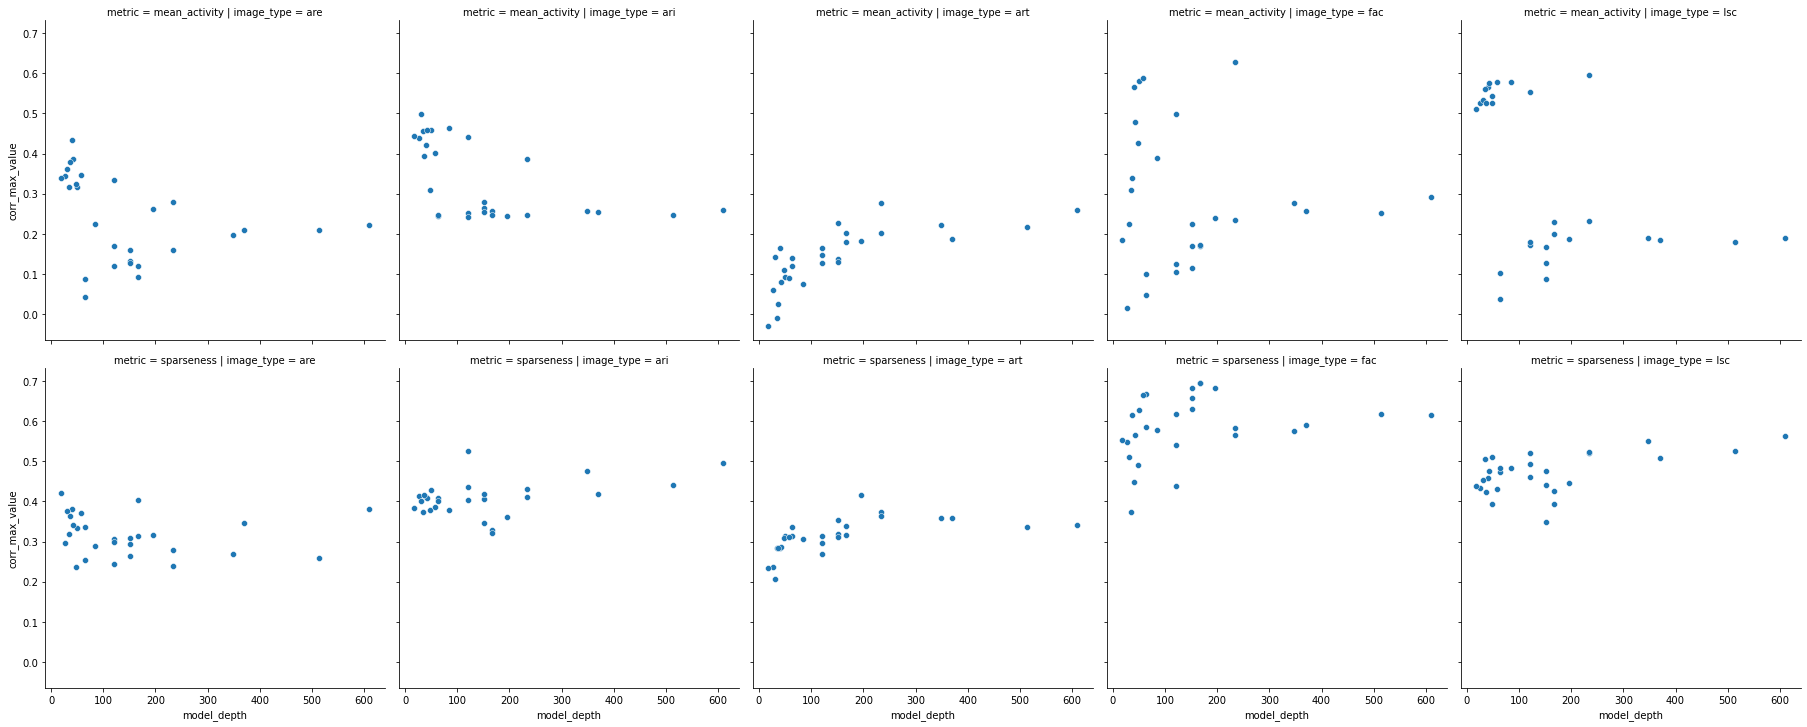

In [73]:
sns.relplot(x='model_depth', y='corr_max_value', row = 'metric', col = 'image_type', 
            data = results[results.metric.isin(['mean_activity','sparseness'])]);

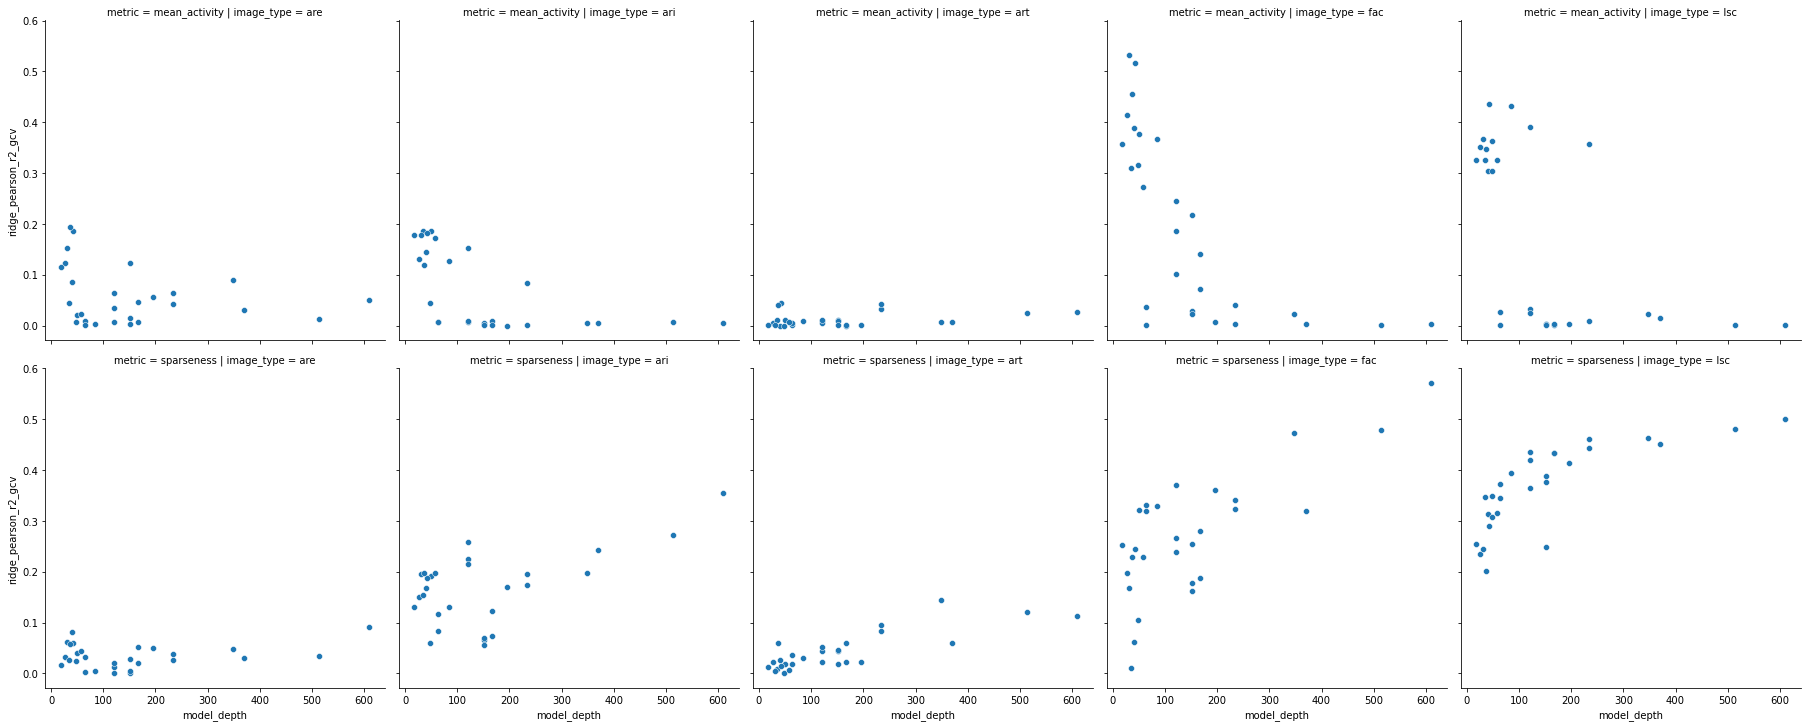

In [74]:
sns.relplot(x='model_depth', y='ridge_pearson_r2_gcv', row = 'metric', col = 'image_type', 
            data = results[results.metric.isin(['mean_activity','sparseness'])]);

In [89]:
model_metadata = (pd.read_csv('../mouseland/model_opts/model_metadata.csv').rename(columns={'model_name': 'model'})
                  .query('train_type != "imagenet"').set_index('model')).drop('train_type', axis = 1)#.to_dict(orient='index'))

# metadata_dictlist = []
# for model in model_metadata:
#     metadata_i = {**model_metadata[model]}
#     metadata_i.pop('layer_metadata', None)
#     metadata_dictlist.append({'model': model, **metadata_i, 
#                               'imagenet_top1': model_metadata[model]['imagenet_top1'], 
#                               'imagenet_top5': model_metadata[model]['imagenet_top5']})
    
# model_params = pd.DataFrame(metadata_dictlist)

In [91]:
results_plus = pd.merge(results[['model','image_type','metric','ridge_pearson_r2_gcv']], model_metadata, on = ['model'])

In [92]:
results_plus

,model,image_type,metric,ridge_pearson_r2_gcv,layer_count,total_feature_count,total_parameter_count
0,mobilenet_v2,are,mean_activity,0.12227,151,19680680,3504872
1,mobilenet_v2,ari,mean_activity,0.00312,151,19680680,3504872
2,mobilenet_v2,art,mean_activity,0.01039,151,19680680,3504872
3,mobilenet_v2,fac,mean_activity,0.21803,151,19680680,3504872
4,mobilenet_v2,lsc,mean_activity,0.00366,151,19680680,3504872
...,...,...,...,...,...,...,...
1535,resnet50,are,sparseness,0.02128,158,32040424,25557032
1536,resnet50,ari,sparseness,0.21563,158,32040424,25557032
1537,resnet50,art,sparseness,0.05170,158,32040424,25557032
1538,resnet50,fac,sparseness,0.26608,158,32040424,25557032


In [100]:
(results_plus[(results_plus['image_type'] == 'lsc') & (results_plus['metric'] == 'mean_activity')]
 .groupby('model')['ridge_pearson_r2_gcv'].mean().sort_values())

model
squeezenet1_0         0.00009
shufflenet_v2_x1_0    0.00023
densenet169           0.00026
mnasnet1_0            0.00034
densenet201           0.00178
googlenet             0.00202
mnasnet0_5            0.00327
mobilenet_v2          0.00366
shufflenet_v2_x0_5    0.00388
wide_resnet101_2      0.00922
densenet121           0.01513
resnet152             0.02186
resnext50_32x4d       0.02388
squeezenet1_1         0.02597
wide_resnet50_2       0.03303
vgg13_bn              0.30354
vgg16_bn              0.30406
alexnet               0.32487
vgg19_bn              0.32489
vgg11_bn              0.32646
vgg16                 0.34729
vgg11                 0.35039
resnet101             0.35631
resnet18              0.36324
vgg13                 0.36649
resnet50              0.39049
resnet34              0.43231
vgg19                 0.43619
Name: ridge_pearson_r2_gcv, dtype: float64

In [95]:
param_corrs = (results_plus.groupby(['image_type','metric']).corrwith(results_plus['ridge_pearson_r2_gcv'])
             .reset_index().drop('ridge_pearson_r2_gcv', axis = 1))

In [96]:
param_corrs[param_corrs['image_type'] == 'lsc']

,image_type,metric,layer_count,total_feature_count,total_parameter_count
44,lsc,cosine_to_imagenet_mean,-0.508834,-0.023134,0.612906
45,lsc,cosine_to_noise_mean,-0.495667,-0.048848,0.570743
46,lsc,distance_to_imagenet_mean,-0.586616,-0.106543,0.654467
47,lsc,distance_to_noise_mean,-0.598573,-0.063560,0.710853
48,lsc,mean_activity,-0.533898,-0.073886,0.607484
49,lsc,mean_cosine_to_imagenet,-0.507854,-0.038673,0.615964
50,lsc,mean_cosine_to_noise,-0.475321,-0.036248,0.543681
51,lsc,mean_distance_to_imagenet,-0.555819,-0.080832,0.630223
52,lsc,mean_distance_to_noise,-0.595243,-0.071753,0.705846
53,lsc,sparseness,0.784356,0.361375,-0.540909


In [97]:
param_corrs[param_corrs['image_type'] == 'fac']

,image_type,metric,layer_count,total_feature_count,total_parameter_count
33,fac,cosine_to_imagenet_mean,-0.390408,0.012617,0.465692
34,fac,cosine_to_noise_mean,-0.230686,-0.300746,-0.253429
35,fac,distance_to_imagenet_mean,-0.559626,-0.094581,0.603499
36,fac,distance_to_noise_mean,-0.586691,-0.126410,0.596272
37,fac,mean_activity,-0.677923,-0.182600,0.690307
38,fac,mean_cosine_to_imagenet,0.036787,-0.222544,-0.346966
39,fac,mean_cosine_to_noise,-0.234762,-0.294507,-0.228652
40,fac,mean_distance_to_imagenet,-0.536559,-0.080012,0.586980
41,fac,mean_distance_to_noise,-0.567499,-0.111976,0.585429
42,fac,sparseness,0.759492,0.463664,-0.345367


In [102]:
corr_results

,model,image_type,model_layer,model_layer_index,metric,corr
0,mobilenet_v2,are,BatchNorm2d-1,2,mean_activity,0.030250
1,mobilenet_v2,are,BatchNorm2d-10,27,mean_activity,-0.091771
2,mobilenet_v2,are,BatchNorm2d-11,30,mean_activity,-0.088786
3,mobilenet_v2,are,BatchNorm2d-12,33,mean_activity,-0.089589
4,mobilenet_v2,are,BatchNorm2d-13,35,mean_activity,-0.088363
...,...,...,...,...,...,...
233635,resnet50,lsc,ReLU-3,20,sparseness,-0.060395
233636,resnet50,lsc,ReLU-5,33,sparseness,-0.013138
233637,resnet50,lsc,ReLU-6,42,sparseness,-0.047882
233638,resnet50,lsc,ReLU-8,55,sparseness,-0.003221


In [104]:
from sklearn.metrics import explained_variance_score as ev_score
from sklearn.metrics import r2_score 

def pearson_r2_score(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]**2

scoring_metrics = {'ev_score': ev_score, 'pearson_r2': pearson_r2_score}

model_csvs = glob('feature_maps/*.csv')
#target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]
target_models = ['alexnet','vgg16','resnet18']

output_file = 'stepwise_regressions.csv'
if os.path.exists(output_file):
    reg_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dictlist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model) 
        data_wide = process_model_data(target_model)
        data_long = process_model_data(target_model, orient='long')
        model_layers = data_wide['model_layer'].unique()

        for metric in tqdm(data_long['metric'].unique(), leave=False):
            for image_type in tqdm(data_long['image_type'].unique(), leave=False):
                running_model_layer_list = []
                for model_layer_index, model_layer in enumerate(tqdm(model_layers, leave = False)):
                    running_model_layer_list.append(model_layer)
                    
                    data_i = data_wide[(data_wide['image_type'] == image_type)]
                    y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
                    X = np.stack([data_i[(data_i['model_layer']==model_layer)][metric].to_numpy() 
                                  for model_layer in running_model_layer_list], axis = 1)
                    regression = RidgeCV(alphas=[1.0], store_cv_values=True, scoring='r2').fit(X,y)
                    y_pred = regression.cv_values_.squeeze()
                    for scoring_metric in scoring_metrics:
                        score = scoring_metrics[scoring_metric](y, y_pred)
                        results_dictlist.append({'model': target_model, 'image_type': image_type, 'metric': metric,
                                                 'score_type': scoring_metric, 'score': score,
                                                 'model_layer': model_layer,
                                                 'model_depth': len(model_layers),
                                                 'model_layer_index': model_layer_index + 1,
                                                 'model_layer_depth': (model_layer_index + 1) / len(model_layers)})

    reg_results = pd.DataFrame(results_dictlist)
    #reg_results.to_csv(output_file, index = None)

In [105]:
reg_results

,model,image_type,metric,score_type,score,model_layer,model_depth,model_layer_index,model_layer_depth
0,mobilenet_v2,are,mean_activity,ev_score,-0.031566,Conv2d-1,151,1,0.006623
1,mobilenet_v2,are,mean_activity,pearson_r2,0.139011,Conv2d-1,151,1,0.006623
2,mobilenet_v2,are,mean_activity,ev_score,-0.032990,BatchNorm2d-1,151,2,0.013245
3,mobilenet_v2,are,mean_activity,pearson_r2,0.148530,BatchNorm2d-1,151,2,0.013245
4,mobilenet_v2,are,mean_activity,ev_score,-0.032752,ReLU6-1,151,3,0.019868
...,...,...,...,...,...,...,...,...,...
84955,resnet50,fac,sparseness,pearson_r2,0.266785,ReLU-17,121,119,0.983471
84956,resnet50,fac,sparseness,ev_score,0.165134,AdaptiveAvgPool2d-1,121,120,0.991736
84957,resnet50,fac,sparseness,pearson_r2,0.266079,AdaptiveAvgPool2d-1,121,120,0.991736
84958,resnet50,fac,sparseness,ev_score,0.165134,Linear-1,121,121,1.000000


In [113]:
reg_results_subset = reg_results[(reg_results['score_type'] == 'ev_score')]
max_transform(reg_results_subset, group_vars = ['metric', 'score_type','image_type'])

,model,image_type,metric,score_type,score,model_layer,model_depth,model_layer_index,model_layer_depth
0,densenet169,fac,sparseness,ev_score,0.391253,_DenseBlock-4,514,512,0.996109
1,vgg11_bn,ari,mean_activity,ev_score,0.195245,ReLU-10,34,33,0.970588
2,densenet201,are,sparseness,ev_score,0.086008,ReLU-196,610,594,0.973770
3,densenet201,lsc,sparseness,ev_score,0.483905,BatchNorm2d-196,610,593,0.972131
4,densenet201,ari,sparseness,ev_score,0.330068,Conv2d-188,610,571,0.936066
5,vgg19,are,mean_activity,ev_score,0.205423,Linear-1,42,38,0.904762
6,vgg19,lsc,mean_activity,ev_score,0.438789,ReLU-18,42,41,0.976190
7,vgg19,art,mean_activity,ev_score,0.075580,MaxPool2d-4,42,28,0.666667
8,vgg13,fac,mean_activity,ev_score,0.532563,Linear-3,30,30,1.000000
9,resnet152,art,sparseness,ev_score,0.144596,BatchNorm2d-132,348,294,0.844828


In [123]:
reg_results_subset = reg_results[(reg_results['score_type'] == 'ev_score') & (reg_results['image_type'].isin(['lsc','fac']))]
max_transform(reg_results_subset, group_vars = ['metric', 'score_type','image_type'])

,model,image_type,metric,score_type,score,model_layer,model_depth,model_layer_index,model_layer_depth
0,densenet169,fac,sparseness,ev_score,0.391253,_DenseBlock-4,514,512,0.996109
1,densenet201,lsc,sparseness,ev_score,0.483905,BatchNorm2d-196,610,593,0.972131
2,vgg19,lsc,mean_activity,ev_score,0.438789,ReLU-18,42,41,0.976190
3,vgg13,fac,mean_activity,ev_score,0.532563,Linear-3,30,30,1.000000


In [124]:
reg_results_subset = reg_results[(reg_results['score_type'] == 'ev_score') & 
                                 (reg_results['image_type'].isin(['lsc','fac']))]
max_transform(reg_results_subset, group_vars = ['metric', 'score_type','image_type'])

,model,image_type,metric,score_type,score,model_layer,model_depth,model_layer_index,model_layer_depth
0,vgg19,lsc,mean_activity,ev_score,0.438789,ReLU-18,42,41,0.976190
1,vgg19,fac,sparseness,ev_score,0.086436,Linear-3,42,42,1.000000
2,resnet18,lsc,sparseness,ev_score,0.291605,AdaptiveAvgPool2d-1,48,47,0.979167
3,vgg13,fac,mean_activity,ev_score,0.532563,Linear-3,30,30,1.000000


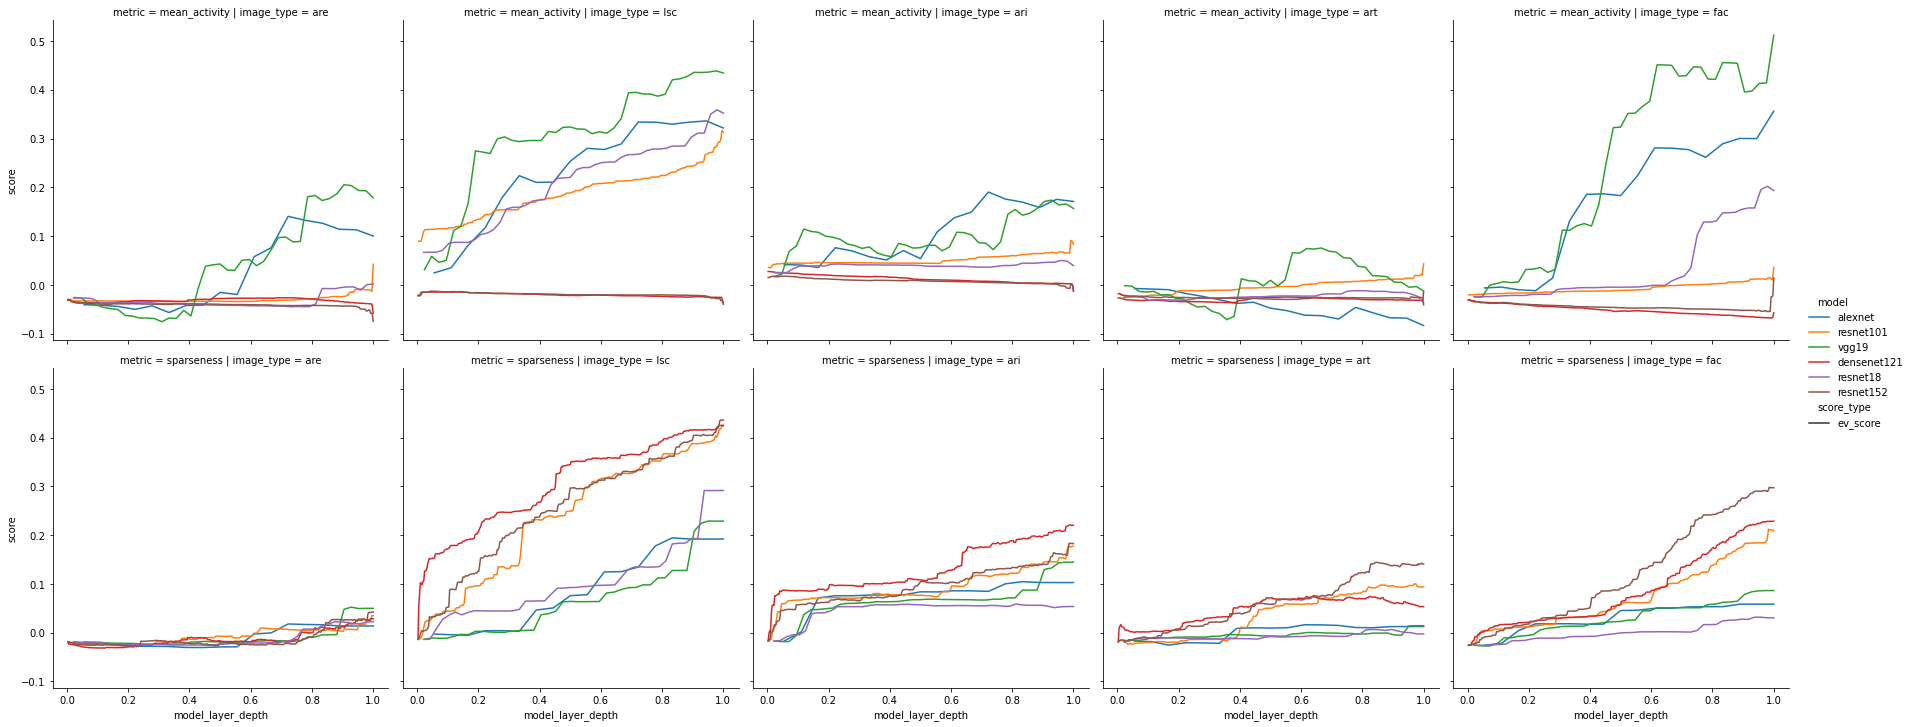

In [182]:
target_models = ['alexnet','vgg19','resnet18', 'densenet121','resnet101','resnet152']

plotting_subset = reg_results[(reg_results['metric'].isin(['mean_activity','sparseness','distance_to_imagenet_mean'])) &
                              (reg_results['score_type'] == 'ev_score') & (reg_results['model'].isin(target_models))]
sns.relplot(x = 'model_layer_depth', y = 'score', hue = 'model', col = 'image_type', row = 'metric', style = 'score_type',  
            kind = 'line', ci = False, data = plotting_subset);

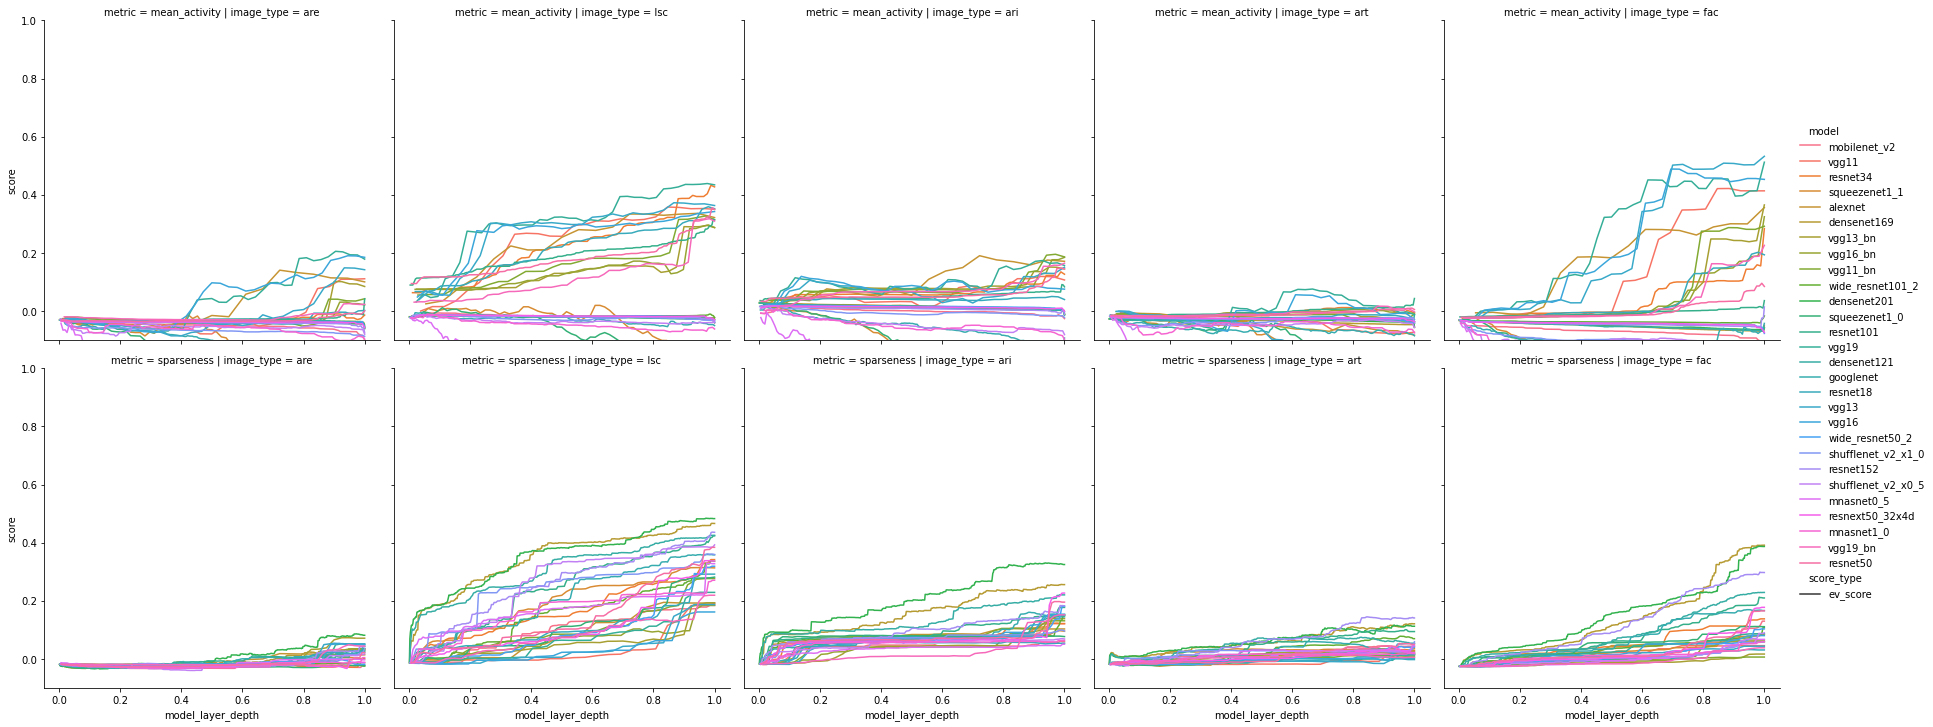

In [190]:
target_models = ['alexnet','vgg19','resnet18', 'densenet121','resnet101','resnet152']

plotting_subset = reg_results[(reg_results['metric'].isin(['mean_activity','sparseness','distance_to_imagenet_mean'])) &
                              (reg_results['score_type'] == 'ev_score')]
p = sns.relplot(x = 'model_layer_depth', y = 'score', hue = 'model', col = 'image_type', row = 'metric', style = 'score_type',  
            kind = 'line', ci = False, data = plotting_subset);
p.set(ylim=(-0.1, 1.0));

In [193]:
max_transform(plotting_subset, measure_var = 'score', group_vars = ['image_type','metric'])

,model,image_type,metric,score_type,score,model_layer,model_depth,model_layer_index,model_layer_depth
0,densenet169,fac,sparseness,ev_score,0.391253,_DenseBlock-4,514,512,0.996109
1,vgg11_bn,ari,mean_activity,ev_score,0.195245,ReLU-10,34,33,0.970588
2,densenet201,are,sparseness,ev_score,0.086008,ReLU-196,610,594,0.973770
3,densenet201,lsc,sparseness,ev_score,0.483905,BatchNorm2d-196,610,593,0.972131
4,densenet201,ari,sparseness,ev_score,0.330068,Conv2d-188,610,571,0.936066
5,vgg19,are,mean_activity,ev_score,0.205423,Linear-1,42,38,0.904762
6,vgg19,lsc,mean_activity,ev_score,0.438789,ReLU-18,42,41,0.976190
7,vgg19,art,mean_activity,ev_score,0.075580,MaxPool2d-4,42,28,0.666667
8,vgg13,fac,mean_activity,ev_score,0.532563,Linear-3,30,30,1.000000
9,resnet152,art,sparseness,ev_score,0.144596,BatchNorm2d-132,348,294,0.844828


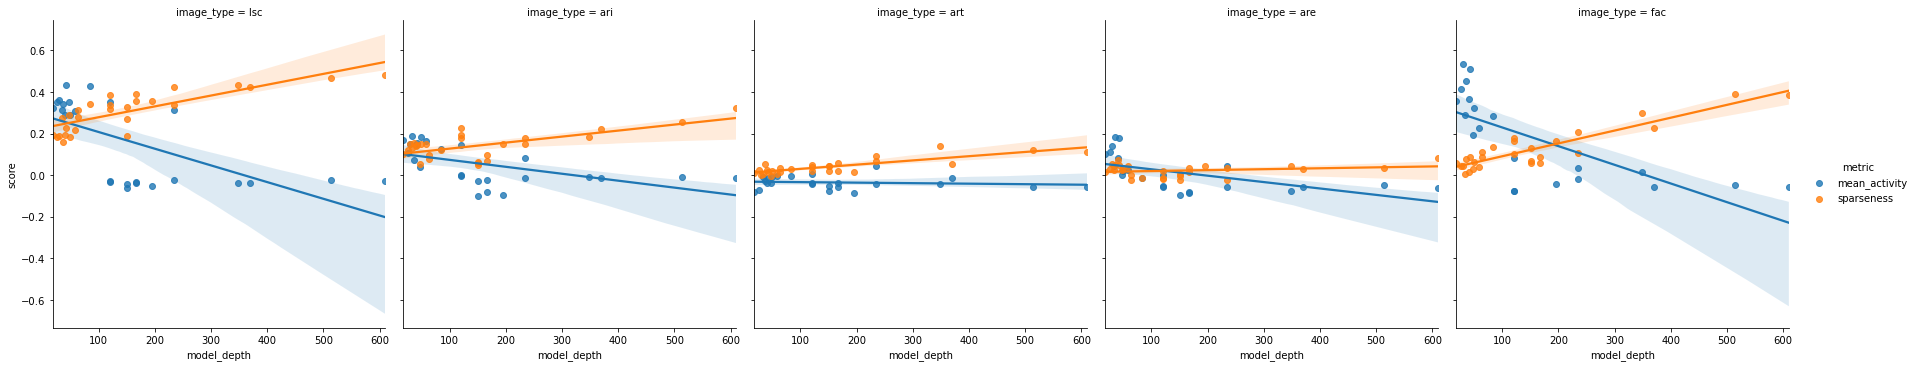

In [205]:
plotting_subset = reg_results[(reg_results['metric'].isin(['mean_activity','sparseness','distance_to_imagenet_mean'])) &
                              (reg_results['score_type'] == 'ev_score') & (reg_results['model_layer_depth'] == 1.0) & 
                              (reg_results['score'] > -0.1)]

sns.lmplot(x = 'model_depth', y = 'score', col = 'image_type', hue = 'metric', data = plotting_subset);

In [132]:
corr_subset = corr_results[(corr_results['model'] == 'vgg19') & (corr_results['image_type'].isin(['lsc'])) &
                           (corr_results['metric'].isin(['mean_activity','sparseness']))]

In [136]:
max_transform(corr_subset, group_vars = ['metric'], measure_var = 'corr')

,model,image_type,model_layer,model_layer_index,metric,corr
0,vgg19,lsc,ReLU-15,34,mean_activity,0.575970
1,vgg19,lsc,Linear-1,38,sparseness,0.474991


In [169]:
plot_data = process_model_data('alexnet')
plot_data = plot_data[plot_data['image_type'] == 'lsc']

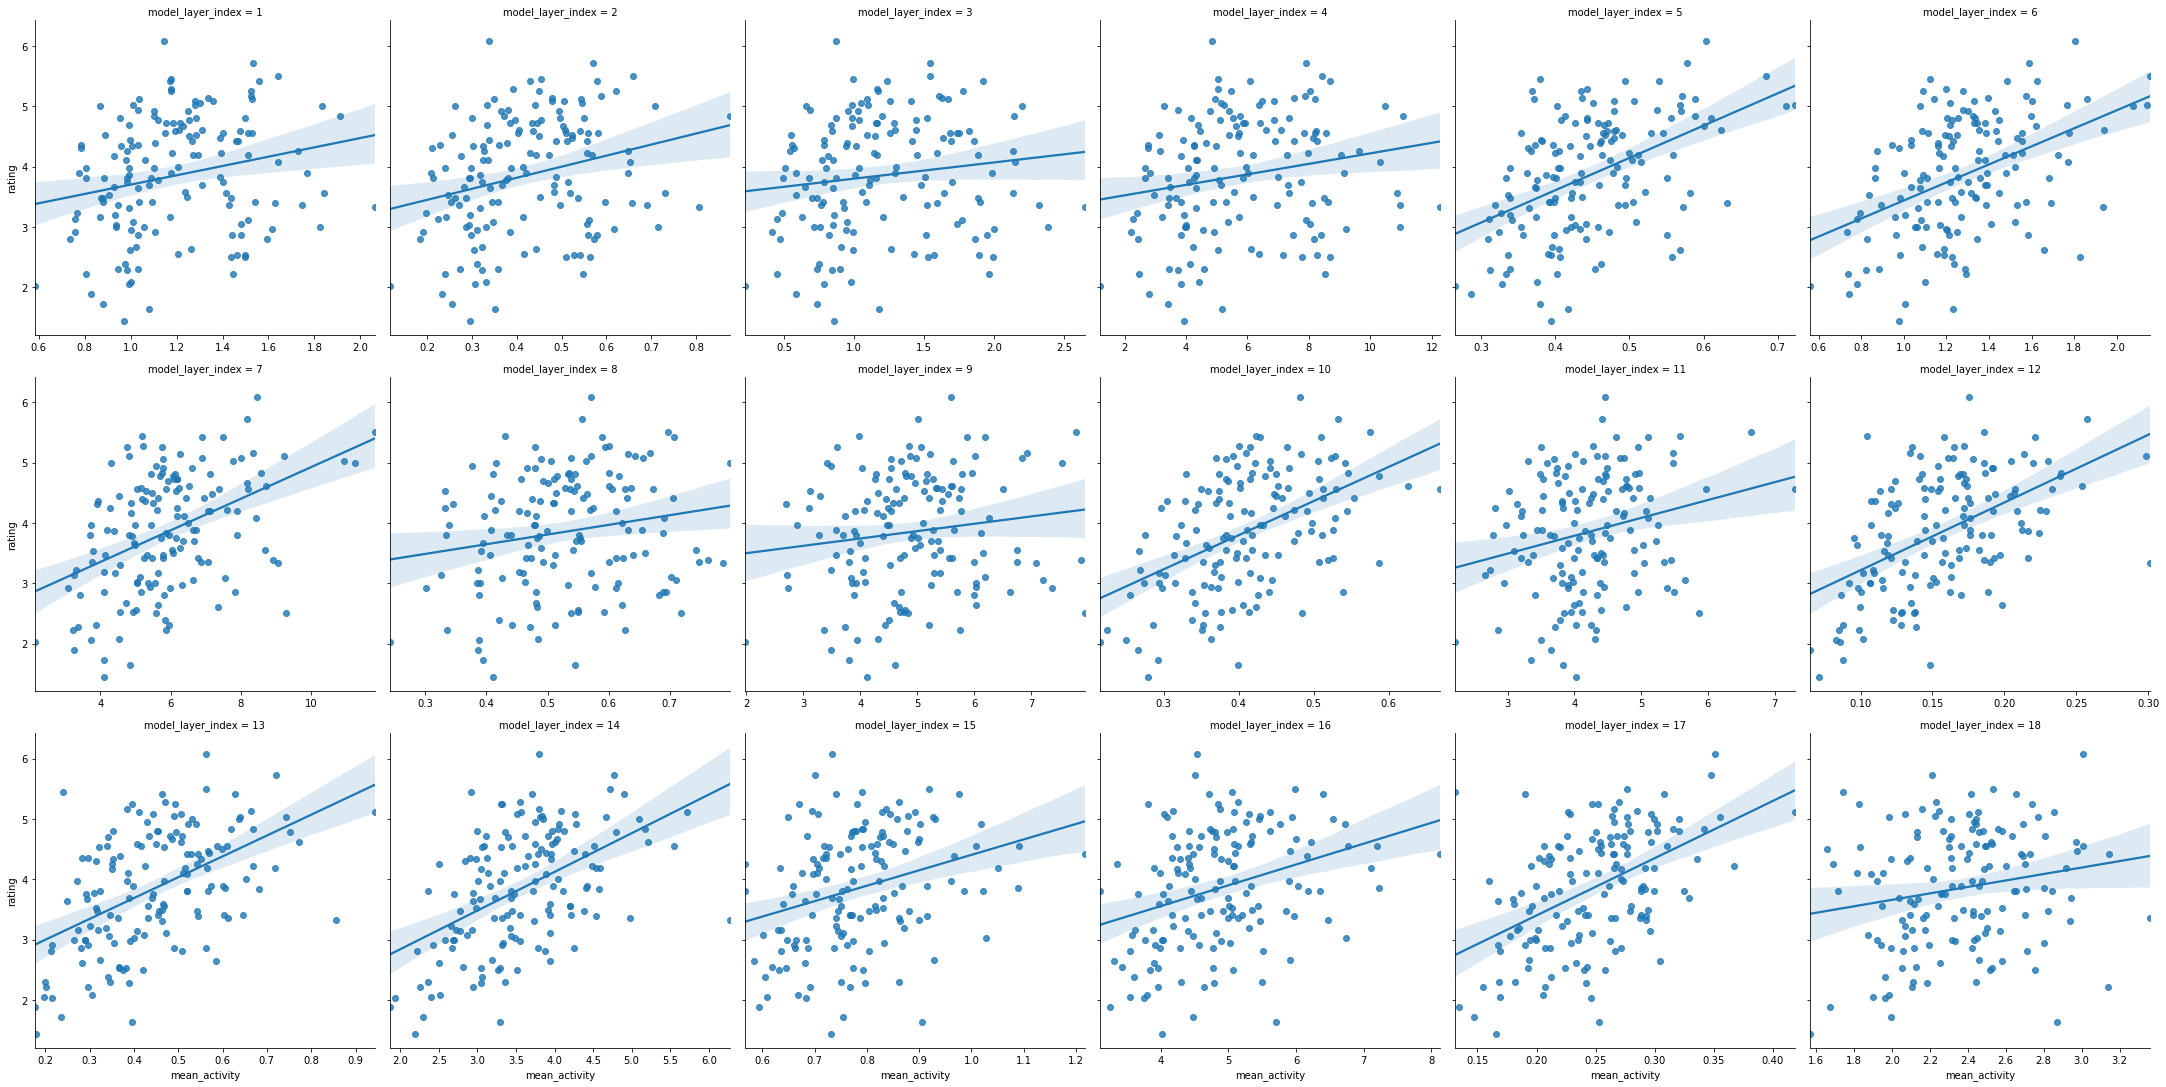

In [163]:
sns.lmplot(x = 'mean_activity', y = 'rating', col = 'model_layer_index', order = 1, col_wrap = 6, 
            data=plot_data, sharex = False);

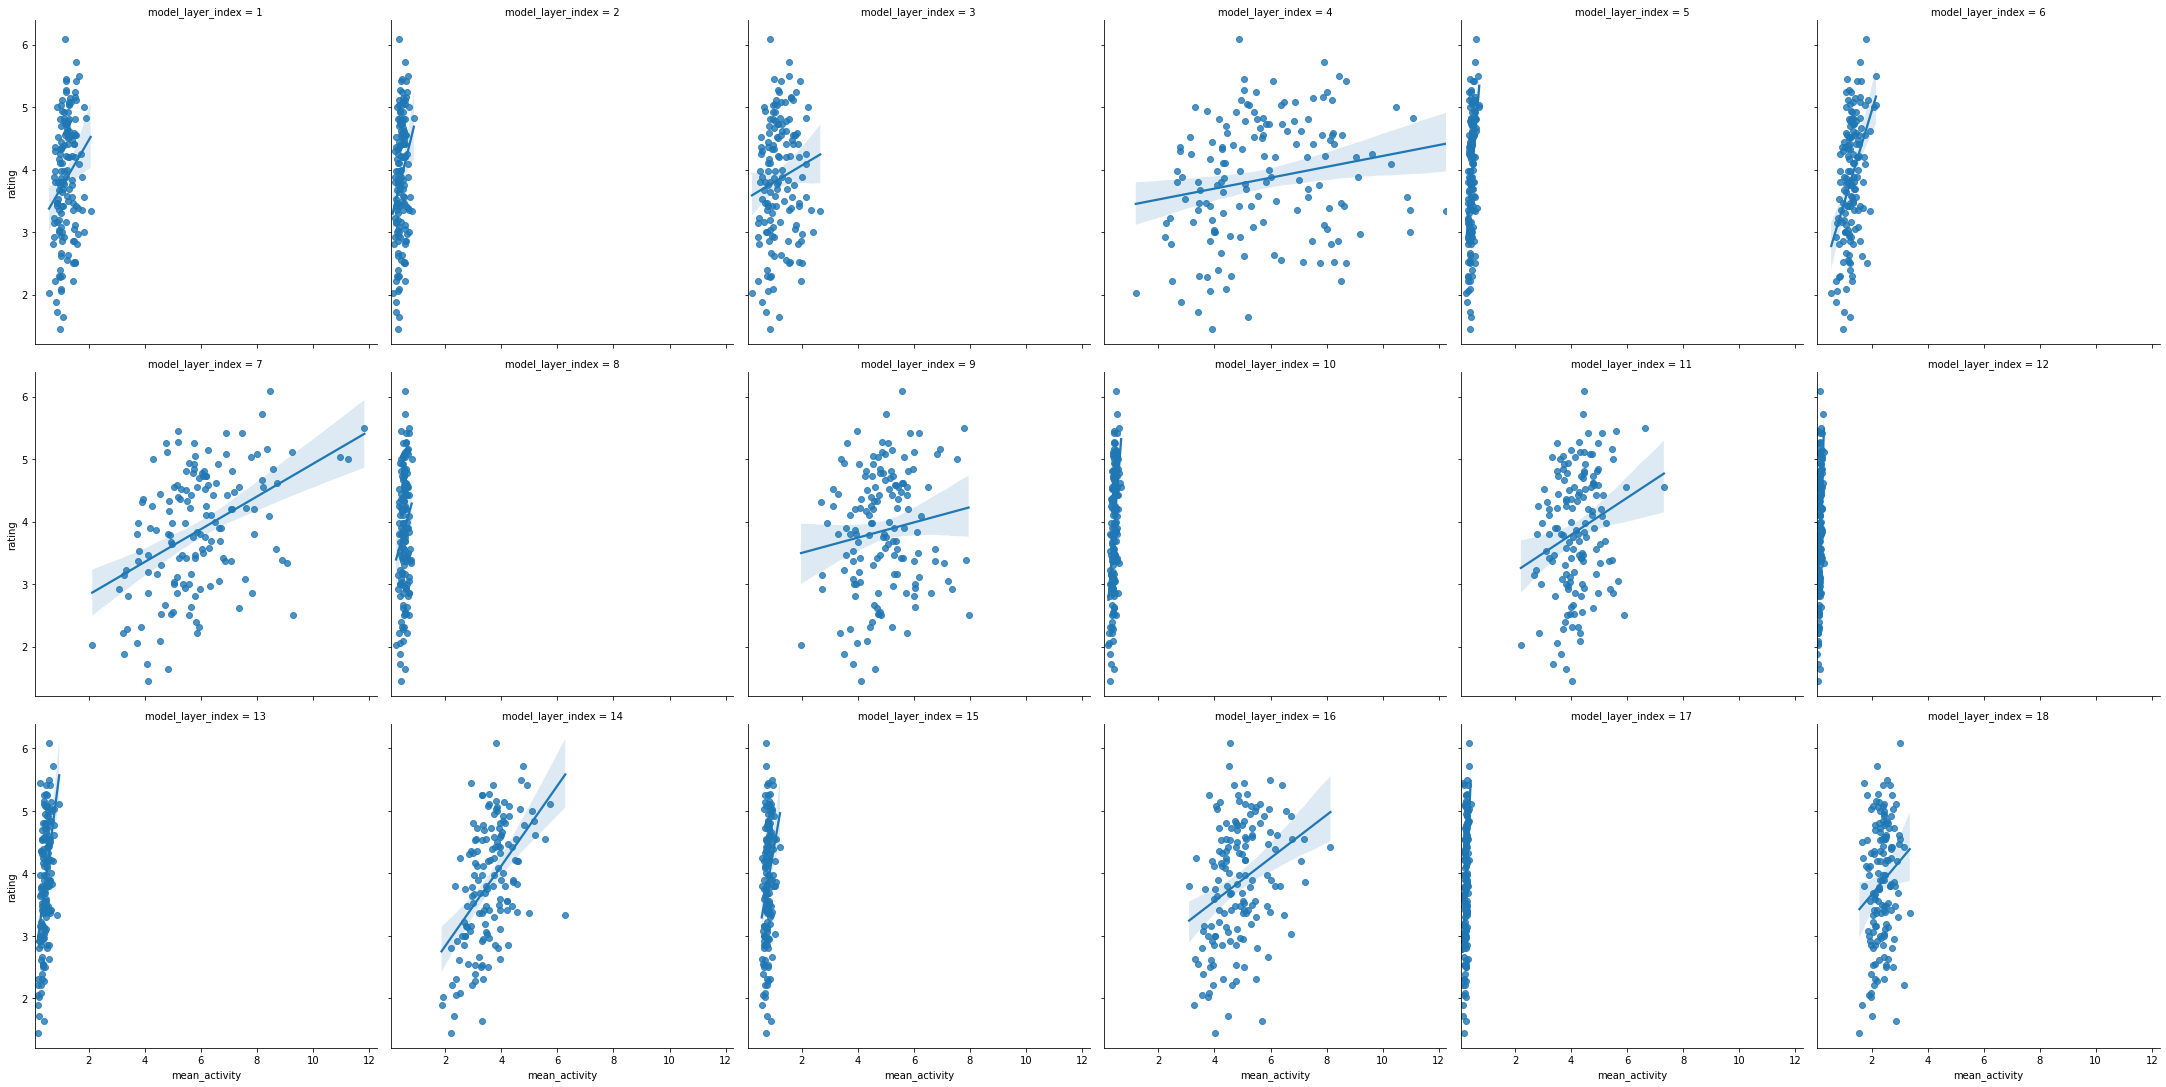

In [167]:
sns.lmplot(x = 'mean_activity', y = 'rating', col = 'model_layer_index', order = 1, col_wrap = 6, 
            data=plot_data, sharex = True);

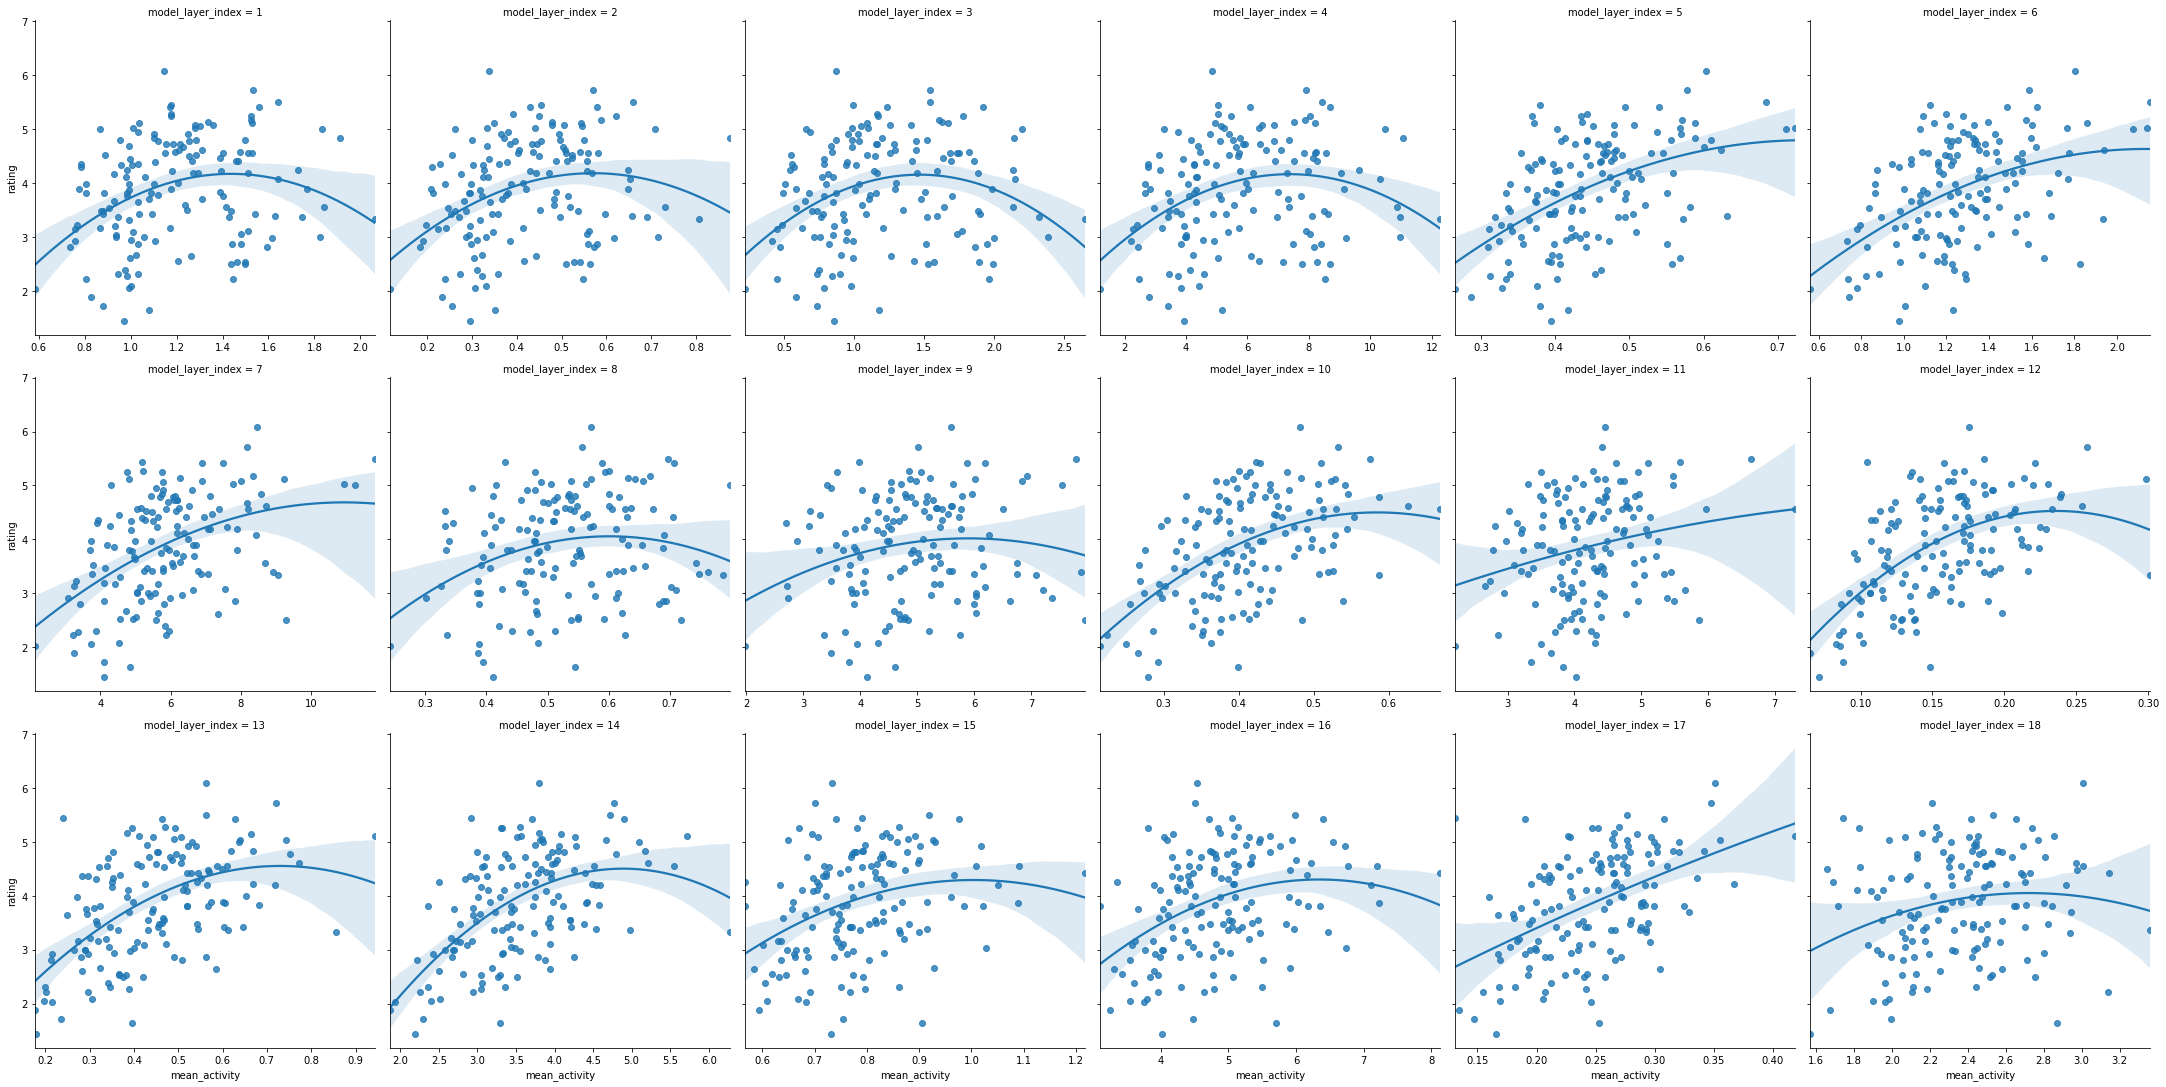

In [164]:
sns.lmplot(x = 'mean_activity', y = 'rating', col = 'model_layer_index', order = 2, col_wrap = 6, 
            data=plot_data, sharex = False);

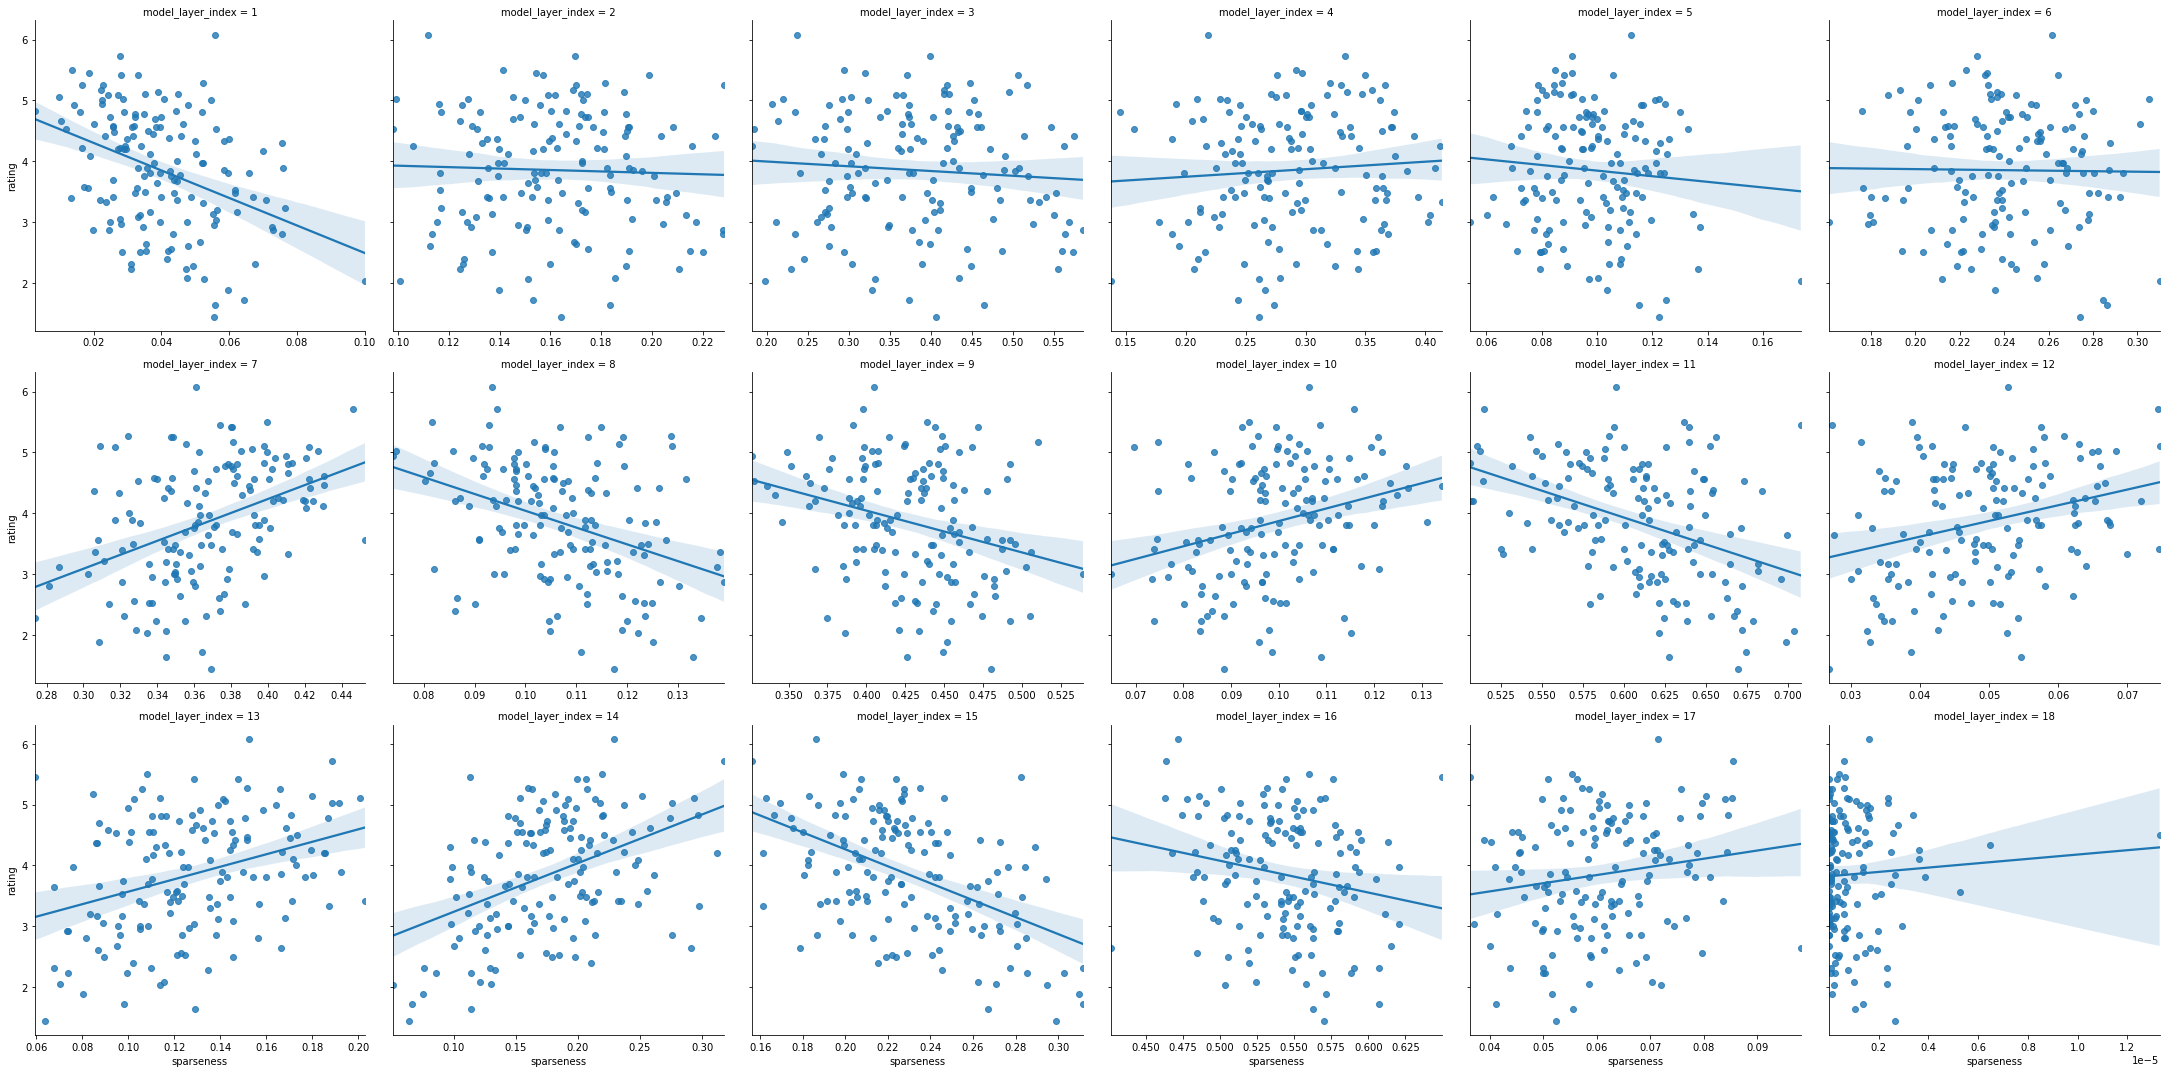

In [168]:
sns.lmplot(x = 'sparseness', y = 'rating', col = 'model_layer_index', order = 1, col_wrap = 6, 
            data=plot_data, sharex = False);

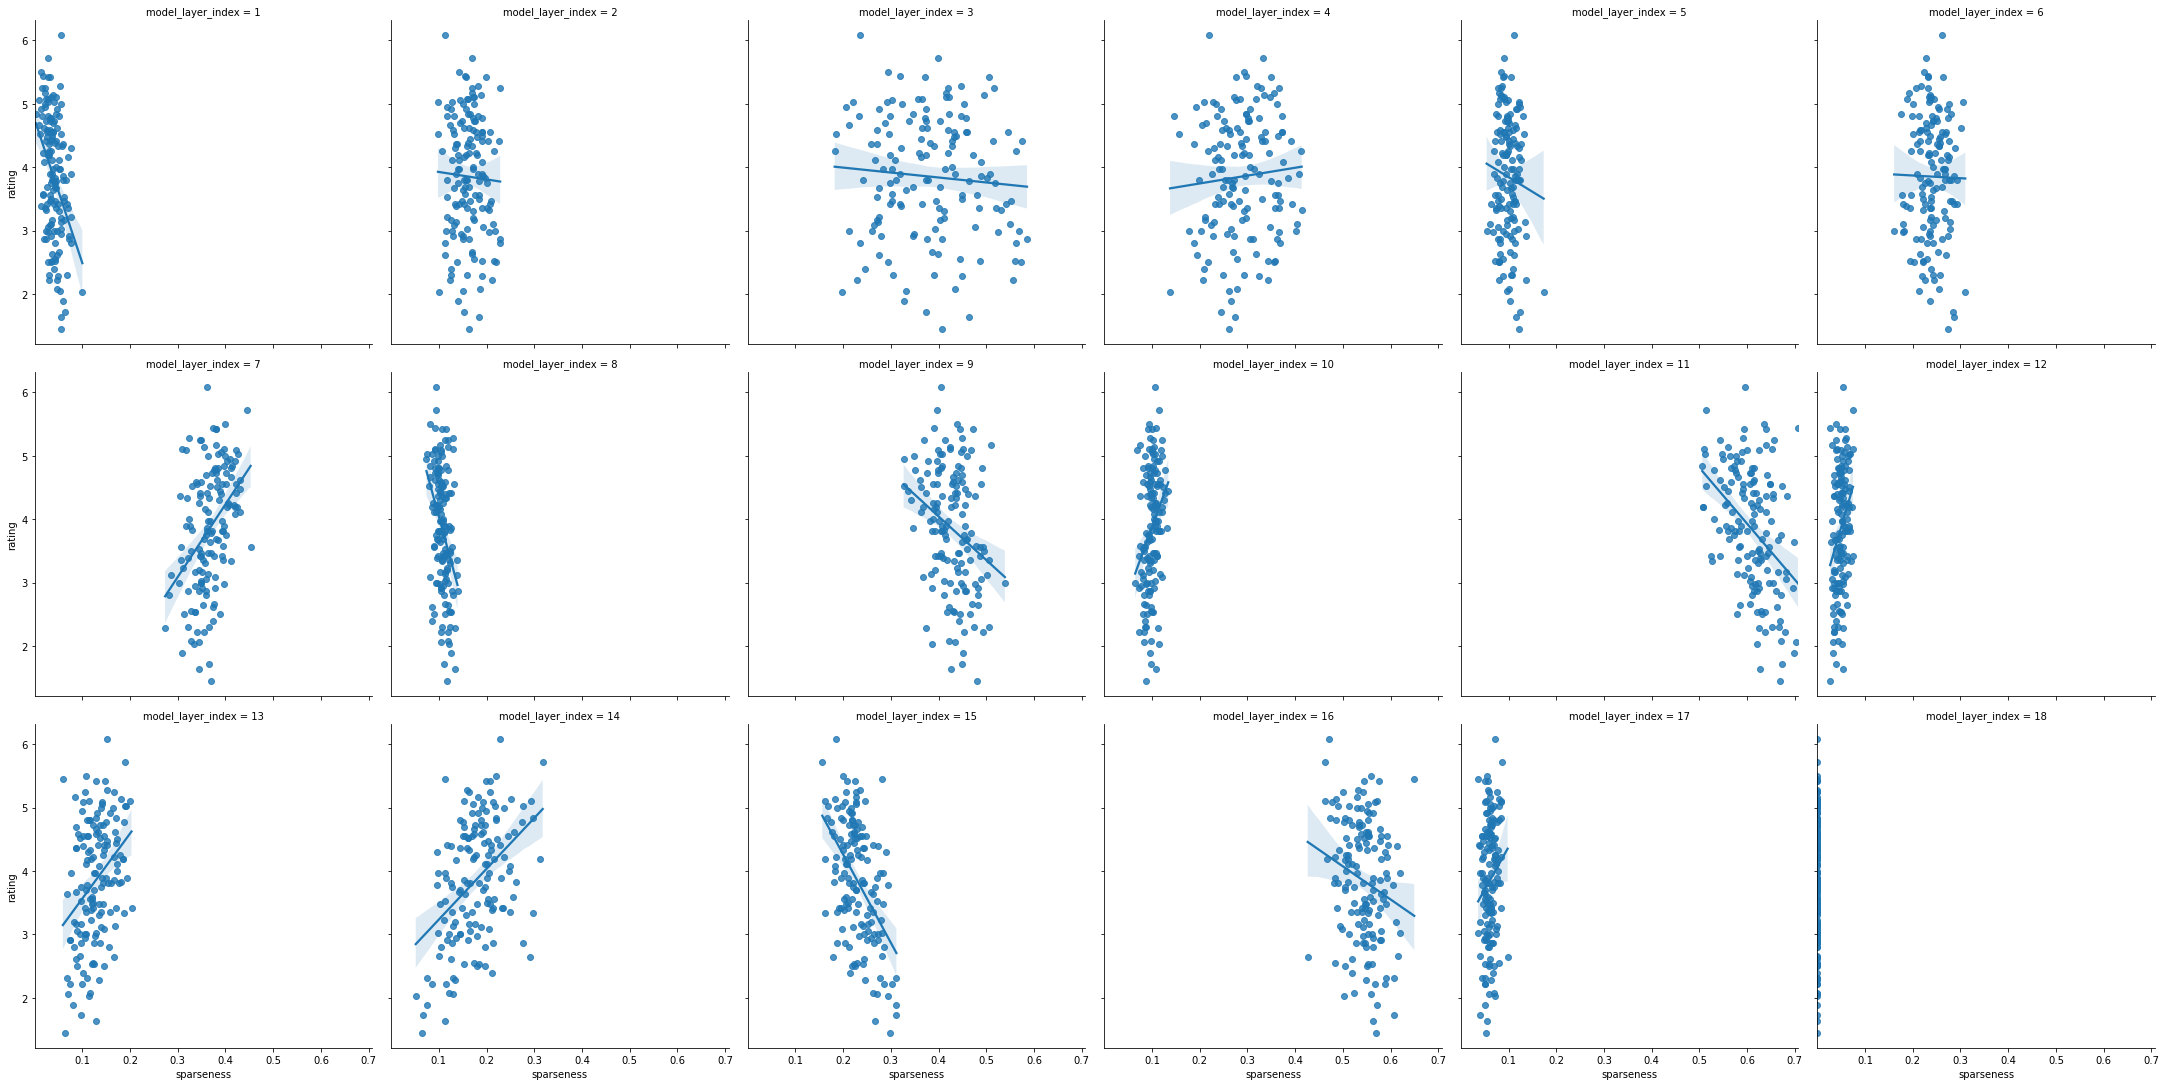

In [166]:
sns.lmplot(x = 'sparseness', y = 'rating', col = 'model_layer_index', order = 1, col_wrap = 6, 
            data=plot_data, sharex = True);

In [ ]:
arr1 = np.random.randn(3)
arr2 = np.random.randn(3)
arr3 = np.random.randn(3)
moving_average = np.mean(np.array((np.mean(arr1), np.mean(arr2), np.mean(arr3))))
combined_average = np.mean(np.stack((arr1,arr2,arr3)))
print('moving average:', moving_average)
print('combined average:', combined_average)